# Creating a Model to Predict the NCAA Tournament

This notebook will be an overview of my entire process of cleaning data and creating a model to try and predict winners in the NCAA tournament. All of the data for this project has already been scraped and downloaded from the following sources: basketball-reference.com, basketball.realgm.com, simplemaps.com and barttorvik.com. 

The data from basketball reference includes data for NCAA tournament games, school locations, team rosters, player stats, recruiting and coach information.

Basketball.realgm.com was used to extract pre-tournament player win shares.

Simplemaps.com has a database that contains latitude and longitude coordinates of cities throughout the world. I will use this data in cojunction with the tournament game locations and school locations to calculate the distance a team has to travel. 

Bart Torvik is the creator of the "T-Rank" website that calculates advanced stats such as adjusted offensive and adjusted defensive efficiency for college basketball teams dating back to 2008. One of the benefits of using this site is the ability to filter the rankings by any timeframe within a season. I downloaded team efficiency numbers for each month of a season as I am interested in learning if performance peaks and valleys throughout a season are important factors in determining tournament game winners. 

The t-rank efficiency numbers should prove to be one of the better predictors of tournament winners and since this information is not available prior to 2008, I will only use data from 2008-2019 to make predictions. 


### Import libraries

In [6425]:
import pandas as pd
import numpy as np
from IPython.display import display, HTML
pd.options.display.max_columns = None
import warnings
warnings.filterwarnings('ignore')

## Calculate Weighted Recruiting Ratings, Roster Continuity & Scoring Continuity

The first tables I will be working with are the rosters and totals tables. The rosters include  the rsci rating for each player and the totals tables include the total games, points scored and minutes played for each player. These two data sources will be used together to calculate a weighted recruiting rating and roster & scoring continuity across seasons. More details will be given in each section, but an overview of the steps to complete this process will be as follows:

- load roster csv files from each season
- combine all roster tables into one table
- clean roster data
- load totals csv files from each season
- combine all totals tables into one table
- clean totals data
- combine the roster table and totals table 
- load tournament player stats to adjust stats to only account for regular season
- compute weighted recuriting ranking and roster & scoring continuity

### Rosters

In [6304]:
#load rosters
roster_2019 = pd.read_csv("roster_2019.csv", na_values=['NA'])
roster_2018 = pd.read_csv("roster_2018.csv", na_values=['NA'])
roster_2017 = pd.read_csv("roster_2017.csv", na_values=['NA'])
roster_2016 = pd.read_csv("roster_2016.csv", na_values=['NA'])
roster_2015 = pd.read_csv("roster_2015.csv", na_values=['NA'])
roster_2014 = pd.read_csv("roster_2014.csv", na_values=['NA'])
roster_2013 = pd.read_csv("roster_2013.csv", na_values=['NA'])
roster_2012 = pd.read_csv("roster_2012.csv", na_values=['NA'])
roster_2011 = pd.read_csv("roster_2011.csv", na_values=['NA'])
roster_2010 = pd.read_csv("roster_2010.csv", na_values=['NA'])
roster_2009 = pd.read_csv("roster_2009.csv", na_values=['NA'])
roster_2008 = pd.read_csv("roster_2008.csv", na_values=['NA'])
roster_2007 = pd.read_csv("roster_2007.csv", na_values=['NA'])

#preview data
roster_2019.head(3)

,player,player_id,season,url_school,school,rsci
0,Jaren Lewis,jaren-lewis-1,2019,abilene-christian,Abilene Christian,NaN
1,Payten Ricks,payten-ricks-1,2019,abilene-christian,Abilene Christian,NaN
2,Jaylen Franklin,jaylen-franklin-1,2019,abilene-christian,Abilene Christian,NaN


### Combine rosters

In [6305]:
#create list of all rosters
roster_list = [roster_2019, roster_2018, roster_2017, 
           roster_2016, roster_2015, roster_2014, roster_2013, 
           roster_2012, roster_2011, roster_2010, roster_2009, 
           roster_2008, roster_2007]

#combine the rosters
rosters = pd.concat(roster_list)

#view row counts of each season
rosters['season'].value_counts()

2017    4791
2016    4766
2014    4756
2019    4751
2015    4743
2018    4725
2013    4645
2012    4595
2011    4565
2010    4508
2008    4397
2009    4380
2007    4346
Name: season, dtype: int64

### Clean RSCI column

RSCI stands for Recruiting Services Consensus Index and is a top 100 ranking system based on rankings across various recruiting services. The rsci column contains a player's recruiting ranking along with the year of the ranking. I need to update this column so that it only includes the ranking. Also, some players inlcude two rankings for multiple years and in those cases, I only want to return the most recent ranking.

To make these changes, I will create a function that will do the following:
- convert each value to a string
- split the string on a comma (for instances with multiple rankings)
- reverse the string list so that the first element in each list is the most recent ranking
- grab the first element in the list
- split the value on a space and return the first element
- convert the value to an integer

First I will fill null values with 0 and then use the apply function to apply the function to each row. 

In [6306]:
rosters[rosters['rsci'].isnull() == False].head()

,player,player_id,season,url_school,school,rsci
88,John Petty,john-petty-2,2019,alabama,Alabama,28 (2017)
89,Tevin Mack,tevin-mack-1,2019,alabama,Alabama,53 (2015)
92,Alex Reese,alex-reese-1,2019,alabama,Alabama,93 (2017)
96,Daniel Giddens,daniel-giddens-1,2019,alabama,Alabama,44 (2015)
156,Luguentz Dort,luguentz-dort-1,2019,arizona-state,Arizona State,76 (2018)


In [6307]:
#create function
def clean_rsci(x):
        return int(str(x).split(',')[::-1][0].split()[0])

#fill null values with 0
rosters['rsci'] = rosters['rsci'].fillna(0)    

#apply function to rsci column
rosters['rsci'] = rosters['rsci'].apply(clean_rsci)

#view results
rosters[rosters['rsci'] > 0].head()

,player,player_id,season,url_school,school,rsci
88,John Petty,john-petty-2,2019,alabama,Alabama,28
89,Tevin Mack,tevin-mack-1,2019,alabama,Alabama,53
92,Alex Reese,alex-reese-1,2019,alabama,Alabama,93
96,Daniel Giddens,daniel-giddens-1,2019,alabama,Alabama,44
156,Luguentz Dort,luguentz-dort-1,2019,arizona-state,Arizona State,76


### Check for duplicate player rows

The roster table should only have one row for each season that a player is in school, so the next step is to ensure players are not duplicated for a single season. The following code will return the number of duplicate rows based on player name, season, and school. 

In [6308]:
rosters.duplicated(['player', 'season', 'url_school']).sum()

3

There are 3 players that have multiple rows for a season and the next line of code will return these players. 

In [6309]:
#return the players that are duplicated 
rosters[rosters.duplicated(['player', 'season', 'url_school'])]

,player,player_id,season,url_school,school,rsci
576,Georgi Funtarov,funtarov-georgi-1,2017,california-davis,UC-Davis,0
4357,Joseph Battle,joseph-battle-1,2017,tulsa,Tulsa,0
1752,Anthony Horton,anthony-horton-2,2014,incarnate-word,Incarnate Word,0


I can now search for all rows containing these players to find out what rows can be removed. 

In [6310]:
#Print all rows containing these players
display(rosters[rosters['player'] == 'Georgi Funtarov'])
display(rosters[rosters['player'] == 'Joseph Battle'])
display(rosters[rosters['player'] == 'Anthony Horton'])

,player,player_id,season,url_school,school,rsci
575,Georgi Funtarov,georgi-funtarov-1,2017,california-davis,UC-Davis,0
576,Georgi Funtarov,funtarov-georgi-1,2017,california-davis,UC-Davis,0
563,Georgi Funtarov,georgi-funtarov-1,2016,california-davis,UC-Davis,0
561,Georgi Funtarov,georgi-funtarov-1,2015,california-davis,UC-Davis,0
544,Georgi Funtarov,georgi-funtarov-1,2014,california-davis,UC-Davis,0


,player,player_id,season,url_school,school,rsci
149,Joseph Battle,joseph-battle-1,2019,appalachian-state,Appalachian State,0
4355,Joseph Battle,battle-joseph-1,2017,tulsa,Tulsa,0
4357,Joseph Battle,joseph-battle-1,2017,tulsa,Tulsa,0


,player,player_id,season,url_school,school,rsci
1742,Anthony Horton,anthony-horton-1,2014,incarnate-word,Incarnate Word,0
1752,Anthony Horton,anthony-horton-2,2014,incarnate-word,Incarnate Word,0
613,Anthony Horton,anthony-horton-1,2012,campbell,Campbell,0
603,Anthony Horton,anthony-horton-1,2011,campbell,Campbell,0


Each player has one row with a player_id outlier that is causing the duplication. I will go ahead and remove those players

In [6311]:
rosters = rosters[rosters['player_id'] != 'funtarov-georgi-1']
rosters = rosters[rosters['player_id'] != 'battle-joseph-1']
rosters = rosters[rosters['player_id'] != 'anthony-horton-2']

### Player totals

In [6312]:
#load player total stats (includes post-season tournaments)
totals_2019 = pd.read_csv("totals_2019.csv", na_values=['NA'])
totals_2018 = pd.read_csv("totals_2018.csv", na_values=['NA'])
totals_2017 = pd.read_csv("totals_2017.csv", na_values=['NA'])
totals_2016 = pd.read_csv("totals_2016.csv", na_values=['NA'])
totals_2015 = pd.read_csv("totals_2015.csv", na_values=['NA'])
totals_2014 = pd.read_csv("totals_2014.csv", na_values=['NA'])
totals_2013 = pd.read_csv("totals_2013.csv", na_values=['NA'])
totals_2012 = pd.read_csv("totals_2012.csv", na_values=['NA'])
totals_2011 = pd.read_csv("totals_2011.csv", na_values=['NA'])
totals_2010 = pd.read_csv("totals_2010.csv", na_values=['NA'])
totals_2009 = pd.read_csv("totals_2009.csv", na_values=['NA'])
totals_2008 = pd.read_csv("totals_2008.csv", na_values=['NA'])
totals_2007 = pd.read_csv("totals_2007.csv", na_values=['NA'])

#preview totals
totals_2019.head(3)

,mp,season,url_school,school,player,player_id,pts,g
0,1056,2019,abilene-christian,Abilene Christian,Jaren Lewis,jaren-lewis-1,469,34
1,1098,2019,abilene-christian,Abilene Christian,Payten Ricks,payten-ricks-1,395,34
2,1092,2019,abilene-christian,Abilene Christian,Jaylen Franklin,jaylen-franklin-1,346,34


### Combine player totals

In [6313]:
#create list of all totals
totals_list = [totals_2019, totals_2018, totals_2017, 
           totals_2016, totals_2015, totals_2014, totals_2013, 
           totals_2012, totals_2011, totals_2010, totals_2009, 
           totals_2008, totals_2007]

#combine all
totals = pd.concat(totals_list)

#view row counts of each season
totals['season'].value_counts()

2017    4791
2016    4766
2014    4756
2019    4751
2015    4743
2018    4725
2013    4645
2012    4595
2011    4565
2010    4508
2008    4397
2009    4380
2007    4346
Name: season, dtype: int64

### Check for duplicate player rows

I want to confirm that the same duplicates found in the rosters are also duplicated in the totals.

In [6314]:
totals[totals.duplicated(['player', 'season', 'url_school'])]

,mp,season,url_school,school,player,player_id,pts,g
576,5.0,2017,california-davis,UC-Davis,Georgi Funtarov,funtarov-georgi-1,4.0,1.0
4357,1.0,2017,tulsa,Tulsa,Joseph Battle,joseph-battle-1,0.0,1.0
1752,16.0,2014,incarnate-word,Incarnate Word,Anthony Horton,anthony-horton-2,4.0,1.0


In [6315]:
#Print all rows containing these players
display(totals[totals['player'] == 'Georgi Funtarov'])
display(totals[totals['player'] == 'Joseph Battle'])
display(totals[totals['player'] == 'Anthony Horton'])

,mp,season,url_school,school,player,player_id,pts,g
575,71.0,2017,california-davis,UC-Davis,Georgi Funtarov,georgi-funtarov-1,6.0,12.0
576,5.0,2017,california-davis,UC-Davis,Georgi Funtarov,funtarov-georgi-1,4.0,1.0
563,94.0,2016,california-davis,UC-Davis,Georgi Funtarov,georgi-funtarov-1,27.0,10.0
561,25.0,2015,california-davis,UC-Davis,Georgi Funtarov,georgi-funtarov-1,7.0,6.0
544,630.0,2014,california-davis,UC-Davis,Georgi Funtarov,georgi-funtarov-1,225.0,26.0


,mp,season,url_school,school,player,player_id,pts,g
149,261.0,2019,appalachian-state,Appalachian State,Joseph Battle,joseph-battle-1,82.0,25.0
4355,51.0,2017,tulsa,Tulsa,Joseph Battle,battle-joseph-1,13.0,13.0
4357,1.0,2017,tulsa,Tulsa,Joseph Battle,joseph-battle-1,0.0,1.0


,mp,season,url_school,school,player,player_id,pts,g
1742,705.0,2014,incarnate-word,Incarnate Word,Anthony Horton,anthony-horton-1,307.0,26.0
1752,16.0,2014,incarnate-word,Incarnate Word,Anthony Horton,anthony-horton-2,4.0,1.0
613,340.0,2012,campbell,Campbell,Anthony Horton,anthony-horton-1,102.0,31.0
603,189.0,2011,campbell,Campbell,Anthony Horton,anthony-horton-1,74.0,21.0


Because there are multiple rows containing stats for the same player in the same season, these rows need to be combined into one row.

In the following code, I will first replace each incorrect player_id with the correct player_id. Then, I will add the stats together for all rows that contain the same player_id, school and season. 

In [6316]:
#combine multiple player rows by adding stats together
totals['player_id'] = totals['player_id'].replace('funtarov-georgi-1', 'georgi-funtarov-1').replace('battle-joseph-1', 'joseph-battle-1').replace('anthony-horton-2', 'anthony-horton-1')
totals = totals.groupby(['player_id','player', 'season', 'url_school', 'school']).sum().reset_index()

In [6317]:
#confirm the changes worked
display(totals[totals['player'] == 'Georgi Funtarov'])
display(totals[totals['player'] == 'Joseph Battle'])
display(totals[totals['player'] == 'Anthony Horton'])

,player_id,player,season,url_school,school,mp,pts,g
21448,georgi-funtarov-1,Georgi Funtarov,2014,california-davis,UC-Davis,630.0,225.0,26.0
21449,georgi-funtarov-1,Georgi Funtarov,2015,california-davis,UC-Davis,25.0,7.0,6.0
21450,georgi-funtarov-1,Georgi Funtarov,2016,california-davis,UC-Davis,94.0,27.0,10.0
21451,georgi-funtarov-1,Georgi Funtarov,2017,california-davis,UC-Davis,76.0,10.0,13.0


,player_id,player,season,url_school,school,mp,pts,g
31072,joseph-battle-1,Joseph Battle,2017,tulsa,Tulsa,52.0,13.0,14.0
31073,joseph-battle-1,Joseph Battle,2019,appalachian-state,Appalachian State,261.0,82.0,25.0


,player_id,player,season,url_school,school,mp,pts,g
3238,anthony-horton-1,Anthony Horton,2011,campbell,Campbell,189.0,74.0,21.0
3239,anthony-horton-1,Anthony Horton,2012,campbell,Campbell,340.0,102.0,31.0
3240,anthony-horton-1,Anthony Horton,2014,incarnate-word,Incarnate Word,721.0,311.0,27.0


### Combine rosters and totals

I will now join the two tables together to get one table. 

In [6318]:
#join the two data frames together.
rosters_totals = pd.merge(rosters, totals, how='left', on=['player_id', 'player', 'url_school', 'school', 'season']) 

#need to rename a player who has a new id and is different from id in tournament data
rosters_totals['player_id'] = rosters_totals['player_id'].replace('anthony-oliverii-1', 'aj-oliverii-1')


### Calculate pre-tournament stats

The table currently contains player stats for an entire season, including post-season tournaments. As the ultimate goal is to use pre-tournament stats to predict what will happen in the NCAA tournament, I need all of my data to only reflect the regular season. To account for this, I will load player tournament stats that will be used calculate a player's regular season stats.

In [6319]:
#player ncaa tournament total stats
tourney_player_totals = pd.read_csv("tourney_2008_2019.csv")

#rename columns so they align with the rosters_totals table
tourney_player_totals = tourney_player_totals.rename({'year_id': 'season', 'school_name': 'school', 'pts': 'tourn_pts', 'mp': 'tourn_mp'}, axis=1)

#preview data
tourney_player_totals.head(3)

,season,tourn_pts,tourn_mp,player,player_id,school,url_school
0,2019,86,241,Kyle Guy,kyle-guy-1,Virginia,virginia
1,2019,99,237,Ty Jerome,ty-jerome-1,Virginia,virginia
2,2011,141,231,Kemba Walker,kemba-walker-1,Connecticut,connecticut


Next, I will join the rosters_totals table with the tourney_player_totals table, drop the additional player column created in the join, and fill null values with 0. 

In [6320]:
#join to tourney data to get pre tourney totals
#suffixes parameter prevents both player columns from renaming when joining. Only one will have the '_y' suffix, which can be deleted in next step.
rosters_totals = pd.merge(rosters_totals, tourney_player_totals, how='left',on=['player_id', 'url_school', 'school', 'season'], suffixes=('', '_y'))

#drop additional player column that was created during the merge
rosters_totals = rosters_totals.drop('player_y', axis=1)

#fill null values with 0 in tourn_pts and tourn_mp 
rosters_totals['tourn_mp'] = rosters_totals['tourn_mp'].fillna(0)
rosters_totals['tourn_pts'] = rosters_totals['tourn_pts'].fillna(0)

Now I can subtract tournament stats from the season stats to get pre-tournament stats

In [6321]:
#subtract tournament stats from season stats
rosters_totals['mp'] = rosters_totals['mp'] - rosters_totals['tourn_mp']
rosters_totals['pts'] = rosters_totals['pts'] - rosters_totals['tourn_pts']

### Weighted recruiting ratings

I could take the average rsci player ranking for each school to get a single rating, but that method would not take playing time into consideration. Instead, I will weight each player's rsci rating based on his total minutes played. The top ranked recruits will typically play a lot of minutes, but this will likely be more useful for recruits who are in the lower tier of the top 100 recruiting rankings. 

The code below will develop these ratings. 

In [6322]:
#create new table to work with in calculating rating for team recruiting weighted by minutes
rsci = rosters_totals

#reverse numbers for rsci column so that 100 is best rating and 1 is worst
rsci['rsci'] = (rsci['rsci']-101).abs()
    
#replace all values of 101 with 0
rsci.loc[rsci['rsci']== 101, 'rsci'] = 0

#multiply rsci by mp
rsci['rsci_mp'] = rsci['rsci'] * rsci['mp']

#group by school/season and sum the rsci_mp and mp columns
rsci = rsci.groupby(['season', 'url_school'])['rsci_mp', 'mp'].sum().reset_index()

#create rsci_rating by dividing rsci_mp by mp
rsci['rsci_rating'] = rsci['rsci_mp'] / rsci['mp']

rsci = rsci[['season', 'url_school', 'rsci_rating']]

Here are the teams with the highest weighted recruiting rating

In [6323]:
#results sorted by the higest rsci rating 
rsci.sort_values('rsci_rating', ascending=False).head(10)

,season,url_school,rsci_rating
1793,2012,kentucky,85.782238
2485,2014,kentucky,82.804509
2835,2015,kentucky,82.680727
398,2008,duke,81.614786
2771,2015,duke,81.383459
1854,2012,north-carolina,80.049404
3471,2017,duke,79.652143
3821,2018,duke,79.373585
845,2009,north-carolina,78.493074
3885,2018,kentucky,78.386667


### Roster continuity

Roster continuity is the percentage of team minutes that are played by the same players from the prior year. Simply calculating the number of players returning does not account for injuries and role changes among players. The steps below show how roster continuity can be calculated. 

The first step is to use the shift method to calculate if each player was on the team the previous year. If the player is a returning player, his minutes from the prior year will be displayed in the new column, otherwise the value will be blank. 

In [6324]:
#ceate new roster_continuity table 
roster_continuity = rosters_totals[['url_school', 'season', 'player_id', 'mp']]

#calculate if a player is a returning player from prior year
roster_continuity['prev_mp'] = roster_continuity.groupby(['url_school','player_id'])['mp'].shift(-1)

#results
roster_continuity.head(10)

,url_school,season,player_id,mp,prev_mp
0,abilene-christian,2019,jaren-lewis-1,1021.0,998.0
1,abilene-christian,2019,payten-ricks-1,1062.0,586.0
2,abilene-christian,2019,jaylen-franklin-1,1057.0,1027.0
3,abilene-christian,2019,jalone-friday-1,502.0,714.0
4,abilene-christian,2019,hayden-farquhar-1,463.0,300.0
5,abilene-christian,2019,bj-maxwell-1,642.0,308.0
6,abilene-christian,2019,joe-pleasant-1,485.0,NaN
7,abilene-christian,2019,damien-daniels-1,484.0,NaN
8,abilene-christian,2019,trey-lenox-1,500.0,171.0
9,abilene-christian,2019,clay-gayman-1,153.0,NaN


The next step is to group the table by school/season and add up all the minutes to create two new columns containing the total team minutes for the current and prior season.

In [6325]:
#group by season and school and create new column with the total number of minutes a team played that season
roster_continuity['cur_total'] = roster_continuity.groupby(['season', 'url_school'])['mp'].transform(sum)
roster_continuity['prev_total'] = roster_continuity.groupby(['season', 'url_school'])['prev_mp'].transform(sum)

#results
roster_continuity.head()

,url_school,season,player_id,mp,prev_mp,cur_total,prev_total
0,abilene-christian,2019,jaren-lewis-1,1021.0,998.0,6650.0,4239.0
1,abilene-christian,2019,payten-ricks-1,1062.0,586.0,6650.0,4239.0
2,abilene-christian,2019,jaylen-franklin-1,1057.0,1027.0,6650.0,4239.0
3,abilene-christian,2019,jalone-friday-1,502.0,714.0,6650.0,4239.0
4,abilene-christian,2019,hayden-farquhar-1,463.0,300.0,6650.0,4239.0


I only want returning players, so I will remove all rows where the prev_mp column is null. Then I will calculate the % of a team's minutes each returning player played for both the current year and the prior year.

In [6326]:
#filter out non returning players
roster_continuity = roster_continuity[roster_continuity['prev_mp'].notnull()]

#calculate the % of team minutes that each player accounted for
roster_continuity['cur_pct'] = roster_continuity['mp'] / roster_continuity['cur_total']
roster_continuity['prev_pct'] = roster_continuity['prev_mp'] / roster_continuity['prev_total']

roster_continuity.head()

,url_school,season,player_id,mp,prev_mp,cur_total,prev_total,cur_pct,prev_pct
0,abilene-christian,2019,jaren-lewis-1,1021.0,998.0,6650.0,4239.0,0.153534,0.235433
1,abilene-christian,2019,payten-ricks-1,1062.0,586.0,6650.0,4239.0,0.159699,0.138240
2,abilene-christian,2019,jaylen-franklin-1,1057.0,1027.0,6650.0,4239.0,0.158947,0.242274
3,abilene-christian,2019,jalone-friday-1,502.0,714.0,6650.0,4239.0,0.075489,0.168436
4,abilene-christian,2019,hayden-farquhar-1,463.0,300.0,6650.0,4239.0,0.069624,0.070771


The final step is to take the minimum between the cur_pct and the prev_pct that was just created, and then sum the values for each school/season to get the continuity percentage. 

In [6327]:
#get the minimum % of team minutes played between current and previous season for each player
roster_continuity['pct'] = roster_continuity[['cur_pct', 'prev_pct']].min(axis=1)

#create continuity column by adding up the pct column and grouping by season and school
roster_continuity['roster_continuity'] = roster_continuity.groupby(['season', 'url_school'])['pct'].transform(sum)

#remove everything but season, url_school and continuity columns and drop duplicate rows
roster_continuity = (roster_continuity[['season', 'url_school', 'roster_continuity']]).drop_duplicates()

Here are the teams with the highest % of roster continuity for the 2019 season.

In [6328]:
roster_continuity[roster_continuity['season'] == 2019].sort_values('roster_continuity', ascending=False).head(10)

,season,url_school,roster_continuity
4509,2019,washington,0.920972
4087,2019,tennessee,0.903560
1635,2019,holy-cross,0.875611
1547,2019,hampton,0.872870
526,2019,cal-state-fullerton,0.843550
3627,2019,san-francisco,0.836292
477,2019,buffalo,0.833576
3444,2019,rider,0.825894
3610,2019,san-diego,0.823319
2590,2019,morehead-state,0.823021


### Scoring continuity

Scoring continuity can be calculated in a similar manner and the results will likely be very similar to roster continuity. 

In [6329]:
#ceate new scoring_continuity table 
scoring_continuity = rosters_totals[['url_school', 'season', 'player_id', 'pts']]

#calculate if a player is a returning player from prior year
scoring_continuity['prev_pts'] = scoring_continuity.groupby(['url_school','player_id'])['pts'].shift(-1)

#group by season and school and create new column with the total number of points a team scored for that season
scoring_continuity['cur_total'] = scoring_continuity.groupby(['season', 'url_school'])['pts'].transform(sum)
scoring_continuity['prev_total'] = scoring_continuity.groupby(['season', 'url_school'])['prev_pts'].transform(sum)

#filter out non returning players
scoring_continuity = scoring_continuity[scoring_continuity['prev_pts'].notnull()]

#calculate the % of team points that each player accounted for
scoring_continuity['cur_pct'] = scoring_continuity['pts'] / scoring_continuity['cur_total']
scoring_continuity['prev_pct'] = scoring_continuity['prev_pts'] / scoring_continuity['prev_total']

#get the minimum % of team points scored between current and previous season for each player
scoring_continuity['pct'] = scoring_continuity[['cur_pct', 'prev_pct']].min(axis=1)

#create continuity column by adding up the pct column and grouping by season and school
scoring_continuity['scoring_continuity'] = scoring_continuity.groupby(['season', 'url_school'])['pct'].transform(sum)

#remove everything but season, url_school and continuity columns and drop duplicate rows
scoring_continuity = (scoring_continuity[['season', 'url_school', 'scoring_continuity']]).drop_duplicates()

Here are the teams with the highest % of scoring continuity for the 2019 season.

In [6330]:
scoring_continuity[scoring_continuity['season'] == 2019].sort_values('scoring_continuity', ascending=False).head(10)

,season,url_school,scoring_continuity
4509,2019,washington,0.900192
1635,2019,holy-cross,0.891762
4087,2019,tennessee,0.887733
1547,2019,hampton,0.884016
4035,2019,temple,0.879096
526,2019,cal-state-fullerton,0.865759
1914,2019,kansas-state,0.856637
3610,2019,san-diego,0.856163
2590,2019,morehead-state,0.855788
4446,2019,virginia-tech,0.846771


### Combine RSCI, roster continuity & scoring continuity tables

Now that I have calcuated RSCI, roster continuity and scoring continuity, I will combine all of the tables into one. 

In [6331]:
#join rsci to roster_continuity first, then  to scoring continuity
rsci_rc_sc = rsci.merge(roster_continuity, on=['season', 'url_school'])
rsci_rc_sc = rsci_rc_sc.merge(scoring_continuity, on=['season', 'url_school'])

#view results
rsci_rc_sc.head()

,season,url_school,rsci_rating,roster_continuity,scoring_continuity
0,2008,air-force,0.000000,0.571353,0.662032
1,2008,akron,0.000000,0.755375,0.767500
2,2008,alabama,29.141471,0.793254,0.836379
3,2008,alabama-am,0.000000,0.673385,0.699361
4,2008,alabama-birmingham,13.174058,0.362590,0.304868


# Calculate career accomplishments for each coach

For all seasons dating back to 1975, the coaches file contains coach information for each ncaa participating school. This includes career totals for wins, losses, and ncaa tournament achievments such as sweet 16 and final 4 appearances. However, as these statistics reflect the entirety of each season, I will once again need to calculate pre-tournament numbers. 

The process for the coaches data will consist of the following:
- load data
- clean the since_cur_schl column
- adjust data for in-season coaching changes
- calculate pre-tournament stats
- Add coach information to the rsci_rc_sc table created in last step

In [6332]:
#load coaches data
coaches = pd.read_csv("coaches_1975_2019.csv")

#preview data
coaches.head(3)

,sweet16_apps_car,season,ncaa_apps_car,since_cur_schl,coach,coach_id,school,url_school,l_car,final4_apps_car,tourney_note,w_car,natl_champs_car,ap_pre
0,NaN,1975,NaN,1971-72,Hank Egan,hank-egan-1,Air Force,air-force,48,NaN,NaN,50,NaN,NaN
1,NaN,1975,1.0,1968-69,C.M. Newton,cm-newton-1,Alabama,alabama,79,NaN,Lost First Round,106,NaN,9.0
2,NaN,1975,NaN,1973-74,Jim Lynam,jim-lynam-1,American,american,49,NaN,NaN,55,NaN,NaN


### Clean since_cur_schl column

First, the since_cur_schl needs to be updated to consist of a single year, and not two years separated by a "-". 

In [6333]:
print(coaches['since_cur_schl'].head())

0    1971-72
1    1968-69
2    1973-74
3    1972-73
4    1974-75
Name: since_cur_schl, dtype: object


In [6334]:
#replace -\d+ will remove a "-" followed by any number of digits
coaches['since_cur_schl'] = coaches['since_cur_schl'].str.replace('-\d+', '').astype(int)

In [6335]:
print(coaches['since_cur_schl'].head())

0    1971
1    1968
2    1973
3    1972
4    1974
Name: since_cur_schl, dtype: int64


### Adjust for in season coaching changes

Although it does not happen often, there are times when there are multiple coaches for a team in a single season due to a firing, resignation, suspension, etc. For example, Jim Boeheim was suspended in the 2016 season and Mike Hopkins was the interim head coach for a number of games that season. Ultimately, I only want to have one row for the school/season with the coach who coached the team in the NCAA tournament. In this case, that was Jim Boeheim, but that can not be determined based on the data. For this instance, I will remove Mike Hopkins.

In [6336]:
coaches[(coaches['season'] == 2016) & (coaches['url_school'] == 'syracuse')]

,sweet16_apps_car,season,ncaa_apps_car,since_cur_schl,coach,coach_id,school,url_school,l_car,final4_apps_car,tourney_note,w_car,natl_champs_car,ap_pre
12849,17.0,2016,32.0,1976,Jim Boeheim*,jim-boeheim-1,Syracuse,syracuse,342,5.0,Lost National Semifinal,985,1.0,NaN
12850,1.0,2016,1.0,2015,Mike Hopkins,mike-hopkins-1,Syracuse,syracuse,5,1.0,Lost National Semifinal,4,NaN,NaN


In [6337]:
#remove Hopkins from 2016 Syracuse
coaches = coaches[~((coaches['coach_id'] == 'mike-hopkins-1') & (coaches['url_school'] == 'syracuse'))]

#confirm that Mike Hopkins was removed
coaches[(coaches['season'] == 2016) & (coaches['url_school'] == 'syracuse')]

,sweet16_apps_car,season,ncaa_apps_car,since_cur_schl,coach,coach_id,school,url_school,l_car,final4_apps_car,tourney_note,w_car,natl_champs_car,ap_pre
12849,17.0,2016,32.0,1976,Jim Boeheim*,jim-boeheim-1,Syracuse,syracuse,342,5.0,Lost National Semifinal,985,1.0,NaN


Besides the Jim Boehoeim suspension, I need to check for other coaching changes in season. I am only going to use data beyond the 2007 season for my modeling, so below are all of the other post 2007 instances where there were multiples coaches in a season. Most of the time, the team does not make the tournament, so I am only concered with the rows where the tourney_note column is populated. 

In [6338]:

coaches[(coaches['season'] > 2007) & (coaches['tourney_note'].isna() == False)][coaches[(coaches['season'] > 2007) & (coaches['tourney_note'].isna() == False)].duplicated(['season', 'url_school'])]

,sweet16_apps_car,season,ncaa_apps_car,since_cur_schl,coach,coach_id,school,url_school,l_car,final4_apps_car,tourney_note,w_car,natl_champs_car,ap_pre
9873,3.0,2008,14.0,2006,Kelvin Sampson,kelvin-sampson-1,Indiana,indiana,227,1.0,Lost First Round,425,NaN,9.0
11478,NaN,2012,1.0,2011,Ray Harper,ray-harper-1,Western Kentucky,western-kentucky,8,NaN,Lost Second Round,11,NaN,NaN
12898,1.0,2016,1.0,2015,Greg Gard,greg-gard-1,Wisconsin,wisconsin,8,NaN,Lost Regional Semifinal,15,NaN,17.0


After looking into the coaching changes for these 3 schools that made the tournament, it looks like selecting the max year for the since_cur_schl column will return the correct results.

The code below finds the index for the row with the most recent year, and then selects that entire row. 

In [6339]:
coaches = coaches.loc[coaches.reindex().groupby(['season', 'url_school'])['since_cur_schl'].idxmax()]

In [6340]:
#confirm that coaches are Dan Dakich, Ray Harper, and Greg Gard
display(coaches[(coaches['season'] == 2008) & (coaches['url_school'] == 'indiana')])
display(coaches[(coaches['season'] == 2012) & (coaches['url_school'] == 'western-kentucky')])
display(coaches[(coaches['season'] == 2016) & (coaches['url_school'] == 'wisconsin')])

,sweet16_apps_car,season,ncaa_apps_car,since_cur_schl,coach,coach_id,school,url_school,l_car,final4_apps_car,tourney_note,w_car,natl_champs_car,ap_pre
9872,NaN,2008,1.0,2007,Dan Dakich,dan-dakich-1,Indiana,indiana,144,NaN,Lost First Round,159,NaN,9.0


,sweet16_apps_car,season,ncaa_apps_car,since_cur_schl,coach,coach_id,school,url_school,l_car,final4_apps_car,tourney_note,w_car,natl_champs_car,ap_pre
11478,NaN,2012,1.0,2011,Ray Harper,ray-harper-1,Western Kentucky,western-kentucky,8,NaN,Lost Second Round,11,NaN,NaN


,sweet16_apps_car,season,ncaa_apps_car,since_cur_schl,coach,coach_id,school,url_school,l_car,final4_apps_car,tourney_note,w_car,natl_champs_car,ap_pre
12898,1.0,2016,1.0,2015,Greg Gard,greg-gard-1,Wisconsin,wisconsin,8,NaN,Lost Regional Semifinal,15,NaN,17.0


In [6341]:
#confirm that each season/school only has one coach. Should return empty.
num_coaches = coaches.groupby(['season','url_school']).size()
num_coaches[num_coaches > 1]

Series([], dtype: int64)

### Calculate pre-tournament stats

Right now, each row includes the coach's stats from that season. For example, Greg Gard won 13 regular season games and 2 NCAA tournament games in 2016 when he took over for Bo Ryan, so the w_car above should be 13 instead 15. Since I am trying to predict what happens in the tournament, I need my data to only include pre-tournament wins. 

To do this, I will transform the tourney_note column into a new column that contains the number of tournament wins for the season.

In [6342]:
#view unique values in tourney_note column
coaches['tourney_note'].value_counts()

Lost First Round           1112
Lost Second Round           736
Lost Regional Semifinal     360
Lost Regional Final         180
Lost National Semifinal      90
Lost Third Round             80
Won National Final           45
Lost National Final          45
Name: tourney_note, dtype: int64

In 2011, the ncaa tournament added an extra round. From 2011-2015, the second round was the round of 64, so a loss in that round means that a team did not have any tournament wins for that year. In that same time frame, a third round loss indicates that a team won 1 game. However, in all other years, the second round was the round of 32, meaning a second round loss means a team won 1 game. The number of teams losing in the second and third round for each year can be seen below. 

In [6343]:
print(coaches[coaches['tourney_note'] == 'Lost Second Round'].groupby(['season']).size())
print(coaches[coaches['tourney_note'] == 'Lost Third Round'].groupby(['season']).size())

season
1979    16
1980    16
1981    16
1982    16
1983    16
1984    16
1985    16
1986    16
1987    16
1988    16
1989    16
1990    16
1991    16
1992    16
1993    16
1994    16
1995    16
1996    16
1997    16
1998    16
1999    16
2000    16
2001    16
2002    16
2003    16
2004    16
2005    16
2006    16
2007    16
2008    16
2009    16
2010    16
2011    32
2012    32
2013    32
2014    32
2015    32
2016    16
2017    16
2018    16
2019    16
dtype: int64
season
2011    16
2012    16
2013    16
2014    16
2015    16
dtype: int64


In [6344]:
#create a function to return the number of tournament wins based on the string specified
def tourney_wins(x):
    if ~(2011 <= x['season'] <= 2015) & int(x['tourney_note'] == 'Lost Second Round'):
        return 1
    elif x['tourney_note'] == 'Lost Third Round':
        return 1
    elif x['tourney_note'] == 'Lost Regional Semifinal':
        return 2
    elif x['tourney_note'] == 'Lost Regional Final':
        return 3
    elif x['tourney_note'] == 'Lost National Semifinal':
        return 4
    elif x['tourney_note'] == 'Lost National Final':
        return 5
    elif x['tourney_note'] == 'Won National Final':
        return 6
    else:
        return 0
    
#apply the function to the tourney_note column and create a new column
coaches['tourney_wins'] = coaches.apply(tourney_wins, axis=1)

#view output
coaches.sort_values(by="tourney_wins", ascending=False).head()

,sweet16_apps_car,season,ncaa_apps_car,since_cur_schl,coach,coach_id,school,url_school,l_car,final4_apps_car,tourney_note,w_car,natl_champs_car,ap_pre,tourney_wins
4728,7.0,1992,9.0,1980,Mike Krzyzewski,mike-krzyzewski-1,Duke,duke,169,6.0,Won National Final,370,2.0,1.0,6
10524,19.0,2010,26.0,1980,Mike Krzyzewski,mike-krzyzewski-1,Duke,duke,279,11.0,Won National Final,868,4.0,9.0,6
11644,11.0,2013,18.0,2001,Rick Pitino*,rick-pitino-1,Louisville,louisville,239,7.0,Won National Final,664,2.0,2.0,6
1119,2.0,1979,3.0,1976,Jud Heathcote,jud-heathcote-1,Michigan State,michigan-state,81,1.0,Won National Final,141,1.0,7.0,6
5839,3.0,1995,11.0,1988,Jim Harrick,jim-harrick-1,UCLA,ucla,152,1.0,Won National Final,335,1.0,6.0,6


Now I need to use the new column to calculate the pre-tournament number of NCAA appearances, sweet 16s, elite 8s, final 4s and national championships. 

In [6345]:
#need to convert all null values to 0
coaches.loc[coaches['ncaa_apps_car'].isnull(), 'ncaa_apps_car'] = 0
coaches.loc[coaches['sweet16_apps_car'].isnull(), 'sweet16_apps_car'] = 0
coaches.loc[coaches['final4_apps_car'].isnull(), 'final4_apps_car'] = 0
coaches.loc[coaches['natl_champs_car'].isnull(), 'natl_champs_car'] = 0

The next functions will create 4 new columns that contain either a 1 or 0 to indiate whether or not a team reached the sweet 16 (2 wins), elite 8 (3 wins), final four (4 wins), or won the tournament (6 wins).

In [6346]:
coaches['sweet16'] = coaches['tourney_wins'].apply(lambda x: 1 if x >=2 else 0)
coaches['elite8'] = coaches['tourney_wins'].apply(lambda x: 1 if x >=3 else 0)
coaches['final4'] = coaches['tourney_wins'].apply(lambda x: 1 if x >=4 else 0)
coaches['champs'] = coaches['tourney_wins'].apply(lambda x: 1 if x ==6 else 0)

#view first 5 results of championship seasons
coaches[coaches['champs'] == 1][['coach', 'season', 'tourney_wins', 'sweet16', 'elite8', 'final4', 'champs']].head(5).sort_values(by="champs", ascending=False)

,coach,season,tourney_wins,sweet16,elite8,final4,champs
214,John Wooden,1975,6,1,1,1,1
326,Bob Knight,1976,6,1,1,1,1
592,Al McGuire,1977,6,1,1,1,1
832,Joe B. Hall,1978,6,1,1,1,1
1119,Jud Heathcote,1979,6,1,1,1,1


The coaches table already includes career appearances for sweet 16 and final 4's, but I also want to add elite 8 appearances. 

In [6347]:
#Get just coachid, season, and elite 8 columns
elite8 = coaches[['coach_id', 'season', 'elite8']]

In [6348]:
#create cumsum of elite 8 wins
elite8['elite8_apps_car'] = elite8.groupby(['coach_id'])['elite8'].cumsum()

#remove elite 8 column to that it is not duplicated when joined back to coaches table
elite8 = elite8.drop('elite8', axis=1)

#join to coaches
coaches = pd.merge(coaches, elite8, on=['coach_id', 'season']) 

Next, I will subtract the individual season accomplishments from the career accomplishment columns to get the pre-tournament numbers.

In [6349]:
coaches['w_car'] = coaches['w_car'].astype(int) - coaches['tourney_wins'].astype(int)
coaches['sweet16_apps_car'] = coaches['sweet16_apps_car'].astype(int) - coaches['sweet16'].astype(int)
coaches['elite8_apps_car'] = coaches['elite8_apps_car'].astype(int) - coaches['elite8'].astype(int)
coaches['final4_apps_car'] = coaches['final4_apps_car'].astype(int) - coaches['final4'].astype(int)
coaches['natl_champs_car'] = coaches['natl_champs_car'].astype(int) - coaches['champs'].astype(int)

The final step in the coaches table is to fill in null values for the ap_pre column. I will fill these in with a value 26 since the AP poll only consists of 25 rankings

In [6350]:
#fill ap_pre null values with 0 and convert from float to integer
coaches['ap_pre'] = coaches['ap_pre'].fillna(26).astype(int)

#remove columns
coaches = coaches[['season', 'url_school', 'coach', 'ap_pre', 'w_car', 'sweet16_apps_car', 'elite8_apps_car', 'final4_apps_car', 'natl_champs_car']]

#view results
coaches.sort_values('w_car', ascending=False).head()

,season,url_school,coach,ap_pre,w_car,sweet16_apps_car,elite8_apps_car,final4_apps_car,natl_champs_car
13568,2019,duke,Mike Krzyzewski,4,1129,24,15,12,5
13216,2018,duke,Mike Krzyzewski,1,1097,23,14,12,5
12865,2017,duke,Mike Krzyzewski,1,1070,23,14,12,5
13787,2019,syracuse,Jim Boeheim*,16,1047,18,7,5,1
12514,2016,duke,Mike Krzyzewski,5,1041,22,14,12,5


### Combine Coaches with RSCI, roster continuity and scoring continuity

In [6351]:
#join tables
rsci_rc_sc_coaches = rsci_rc_sc.merge(coaches, on=['season', 'url_school'])

#view results
rsci_rc_sc_coaches.head()

,season,url_school,rsci_rating,roster_continuity,scoring_continuity,coach,ap_pre,w_car,sweet16_apps_car,elite8_apps_car,final4_apps_car,natl_champs_car
0,2008,air-force,0.000000,0.571353,0.662032,Jeff Reynolds,26,16,0,0,0,0
1,2008,akron,0.000000,0.755375,0.767500,Keith Dambrot,26,112,0,0,0,0
2,2008,alabama,29.141471,0.793254,0.836379,Mark Gottfried,26,266,1,1,0,0
3,2008,alabama-am,0.000000,0.673385,0.699361,Vann Pettaway,26,140,0,0,0,0
4,2008,alabama-birmingham,13.174058,0.362590,0.304868,Mike Davis,26,153,1,1,1,0


# Cities

The cities table includes the latitude and longitude coordinates of cities across the world that will be used to calculate the distance between each school and the location of the tournament game. After loading in the file, the primary steps are to add new cities that are not available and create a concatenation of city and state in a format that can be joined to other tables

In [6352]:
#load cities file with lat long coordninates
cities = pd.read_csv("worldcities.csv")

#preview data
cities.head(3)

,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
0,Tokyo,Tokyo,35.6850,139.7514,Japan,JP,JPN,Tōkyō,primary,35676000.0,1392685764
1,New York,New York,40.6943,-73.9249,United States,US,USA,New York,NaN,19354922.0,1840034016
2,Mexico City,Mexico City,19.4424,-99.1310,Mexico,MX,MEX,Ciudad de México,primary,19028000.0,1484247881


### Clean cities data

In [6353]:
#exclude all non-us cities
cities = cities[cities['country'] == 'United States']

#filter out unnecessary columns
cities = cities[['city_ascii', 'admin_name', 'lat', 'lng']]

#rename city_asci to city and admin_name to state
cities = cities.rename({'city_ascii': 'city', 'admin_name': 'state'}, axis=1)

#create new cities not found in table
new_cities = [pd.Series(['Boiling Springs', 'North Carolina', 35.2543, -81.6670], index=cities.columns),
              pd.Series(['Hamilton', 'New York', 42.8270, -75.5447], index=cities.columns),
              pd.Series(['South Orange', 'New Jersey',  40.7490, -74.2613], index=cities.columns),
              pd.Series(['Allegany', 'New York', 42.0901, -78.4942], index=cities.columns),
              pd.Series(['Moon Township','Pennsylvania',  40.5201, -80.2107], index=cities.columns),
              pd.Series(['Riverdale', 'New York', 40.9005, -73.9064], index=cities.columns),
              pd.Series(['Itta Bena', 'Mississippi',  33.4951, -90.3198], index=cities.columns),
              pd.Series(['Loudonville', 'New York',  42.7048, -73.7548], index=cities.columns),
              pd.Series(['Chestnut Hill', 'Massachusetts',  42.6362, -72.2009], index=cities.columns),
              pd.Series(['Northridge', 'California',  34.2283, -118.5368], index=cities.columns)]

#append new cities to cities table
cities = cities.append(new_cities , ignore_index=True)

#concatenate city and state column
cities['city_id'] = cities['city'] +'_' + cities['state']

#clean up city_id column to the same format in school_ids table
cities['city_id'] = cities['city_id'].str.replace(' ', '_').str.replace(',', '').str.replace('.', '').str.lower()

#get just the city_id, lat and lng columns
cities = cities[['city_id', 'lat', 'lng']]

#print resulting table
cities.head(3)

,city_id,lat,lng
0,new_york_new_york,40.6943,-73.9249
1,los_angeles_california,34.1139,-118.4068
2,chicago_illinois,41.8373,-87.6862


# School Location

The school_loc file has the location of each school and the next step is to update the location column to be in the same format as the city_id column in the cities table. Then, I can join the two tables together to get the coordinates for each school. 

The complete steps are as follows:
- load school_loc file
- rename some locations
- join table to cities table to get coordinates
- add location and coordinates to rsci_rc_sc_coaches table

In [6354]:
#load school_loc data
school_loc = pd.read_csv("school_loc.csv")

#preview school loc data
school_loc.head(3)

,school,url_school,location
0,Abilene Christian Wildcats,abilene-christian,"Abilene, Texas"
1,Air Force Falcons,air-force,"USAF Academy, Colorado"
2,Akron Zips,akron,"Akron, Ohio"


### Update school locations

Some schools are incorrect or the spelling is not consistent with the cities table, so the below code will update those location names. 

In [6355]:
school_loc['location'] = school_loc['location'].replace({'Villanova, Pennsylvania': 'Philadelphia, Pennsylvania', 
                                 'Mississippi State, Mississippi': 'Starkville, Mississippi', 
                                 'University, Mississippi': 'Oxford, Mississippi', 
                                 'St. Bonaventure, New York': 'Allegany, New York',
                                 'Washington, D.C.': 'Washington, District of Columbia',
                                 'University Park, Pennsylvania': 'State College, Pennsylvania'
                                 })

### Create loc_id column with updated location format

In [6356]:
#create new column with underscore separting city/state so that can be joined to cities
school_loc['loc_id'] = school_loc['location'].str.replace(' ', '_').str.replace(',', '').str.replace('.', '').str.lower()

### Join school_loc to the cities table

The coordinates will be null for some schools as I only updated the incorrect locations for NCAA tournament teams. These rows will eventually be removed when I join to the table containing NCAA tournament games. 

In [6357]:
#join tables
school_loc = pd.merge(school_loc, cities, how='left', left_on = 'loc_id', right_on= 'city_id')

#drop city_id, loc_id, and location columns
school_loc = school_loc.drop(['city_id', 'loc_id', 'location'], axis=1)

#print results
school_loc.head()

,school,url_school,lat,lng
0,Abilene Christian Wildcats,abilene-christian,32.4543,-99.7384
1,Air Force Falcons,air-force,NaN,NaN
2,Akron Zips,akron,41.0798,-81.5219
3,Alabama A&M Bulldogs,alabama-am,NaN,NaN
4,Alabama Crimson Tide,alabama,33.2348,-87.5266


## Combine school_loc with rsci_rc_sc_coaches

In [6358]:
#join tables
rsci_rc_sc_coaches_loc = rsci_rc_sc_coaches.merge(school_loc, on=['url_school'])

#view results
rsci_rc_sc_coaches_loc.head()

,season,url_school,rsci_rating,roster_continuity,scoring_continuity,coach,ap_pre,w_car,sweet16_apps_car,elite8_apps_car,final4_apps_car,natl_champs_car,school,lat,lng
0,2008,air-force,0.0,0.571353,0.662032,Jeff Reynolds,26,16,0,0,0,0,Air Force Falcons,NaN,NaN
1,2009,air-force,0.0,0.629643,0.714570,Jeff Reynolds,26,26,0,0,0,0,Air Force Falcons,NaN,NaN
2,2010,air-force,0.0,0.507939,0.468899,Jeff Reynolds,26,36,0,0,0,0,Air Force Falcons,NaN,NaN
3,2011,air-force,0.0,0.845599,0.800762,Jeff Reynolds,26,52,0,0,0,0,Air Force Falcons,NaN,NaN
4,2012,air-force,0.0,0.666985,0.668649,Dave Pilipovich,26,2,0,0,0,0,Air Force Falcons,NaN,NaN


# Torvik Efficiency Stats

I have one file containing team adjusted efficiency stats for an entire season up until selection sunday. The other 4 files contain team adjusted efficiency stats for each month of the college basketball season. Adjusted offensive efficiency and adjusted defensive efficiency are the competition adjusted number of points scored and given up per 100 possessions. The two other main stats included in the t-rank table are WAB and barthag. Barthag is just another name for the pythagorean expectation rating and is based on the adjoe and adjde ratings. WAB stands for wins above bubble and is a measure of how many more games a team has won compared to how many of those game a bubble team would have expected to win. The full list of stats included in the t-rank table are below:

- barthag
- efg/efg
- tor/tord
- orb/drb
- ftr/ftrd
- two_pct/two_pctd
- three_pct/three_pctd
- adj_t
- wab


Here are the steps I will take to prepare this data:

- load data
- clean each table
- combine all tables into one t-rank table
- join rsci_rc_sc_coaches_loc and t-rank table to school spellings table to get team_id
- join t-rank and rsci_rc_sc_coaches_loc table on team_id.

In [6359]:
#load t-rank data
trank_november = pd.read_csv("trank_november.csv")
trank_december = pd.read_csv("trank_december.csv")
trank_january = pd.read_csv("trank_january.csv")
trank_febmarch = pd.read_csv("trank_febmarch.csv")
trank_all = pd.read_csv("trank_fullseason.csv")

#preview data
trank_all.tail()

,season,school,wins,adjoe,adjde,barthag,efg,efgd,tor,tord,orb,drb,ftr,ftrd,two_pct,two_pctd,three_pct,three_pctd,adj_t,wab
4172,2012,"Ohio St.\n2 seed, Final Four",27,115.7\n9,85.2\n1,.9714\n1,52.5\n49,46.3\n57,17.4\n26,22.5\n55,35.7\n51,24.9\n2,37\n154,28.6\n25,53.8\n12,45.3\n73,32.6\n244,32.2\n76,68.1\n76,7.9\n8
4173,2011,"Ohio St.\n1 seed, Sweet Sixteen",32,123.4\n1,89.6\n8,.9756\n1,56\n4,48.4\n132,15.8\n7,23.3\n30,35.3\n76,28.1\n25,37.8\n170,20.9\n1,53.2\n10,47.1\n147,41.3\n3,33.9\n138,65.5\n234,12\n1
4174,2010,"Kansas\n1 seed, R32",32,120.0\n1,88.2\n6,.9718\n1,55.1\n11,43\n3,18.5\n72,20.2\n186,38.2\n27,31.7\n126,42.4\n68,31.2\n46,52.3\n22,40\n2,40.9\n5,33\n110,68.4\n114,11.7\n1
4175,2009,"Memphis\n2 seed, Sweet Sixteen",31,109.3\n55,81.6\n1,.9668\n1,49.3\n155,40.4\n1,18.2\n40,23\n51,38.2\n26,30.3\n67,39.7\n84,34.3\n125,49.9\n91,39\n2,32\n259,29.3\n7,67.8\n127,6.9\n8
4176,2008,"Kansas\n1 seed, CHAMPS",30,121.0\n1,85.6\n3,.9816\n1,56.3\n4,44.8\n18,18.7\n41,22.9\n70,38\n17,29\n34,37.5\n140,30.8\n56,54.8\n7,40.9\n4,39.9\n13,34\n106,69.5\n91,9.9\n3


### Clean tables

As all 5 of these tables needs a lot of cleaning, I will create a function to help with this process.

For the school column, the function will:
- split on the seed number
- select the first element
- remove the whitespace at the end
- convert string to lowercase
- rename 5 schools

Each of the stat columns also contain a national ranking that I am not interested in keeping, so the function will split on whitespace and select the first element.

In [6360]:
#create function to update tables
def update_trank(df):
        #strip on seed number and return 1st element and remove space at end and make lowercase
        df['school'] = df['school'].str.split('\d+').str[0].str.rstrip().str.lower()
        df['school'] = df['school'].astype(str)
        df['school'] = df['school'].str.replace('arkansas little rock' , 'ark little rock')
        df['school'] = df['school'].str.replace('louisiana lafayette' , 'ull')
        df['school'] = df['school'].str.replace('cal st. bakersfield' , 'cal-state-bakersfield')
        df['school'] = df['school'].str.replace('mississippi valley st.' , 'mississippi-valley-state')
        df['school'] = df['school'].str.replace('arkansas pine bluff' , 'ark pine bluff')
        df['adjoe'] = df['adjoe'].str.split('\s+').str[0].astype(float)
        df['adjde'] = df['adjde'].str.split('\s+').str[0].astype(float)
        df['barthag'] = df['barthag'].str.split('\s+').str[0].astype(float)
        df['efg'] = df['efg'].str.split('\s+').str[0].astype(float)
        df['efgd'] = df['efgd'].str.split('\s+').str[0].astype(float)
        df['tor'] = df['tor'].str.split('\s+').str[0].astype(float)
        df['tord'] = df['tord'].str.split('\s+').str[0].astype(float)
        df['orb'] = df['orb'].str.split('\s+').str[0].astype(float)
        df['drb'] = df['drb'].str.split('\s+').str[0].astype(float)
        df['ftr'] = df['ftr'].str.split('\s+').str[0].astype(float)
        df['ftrd'] = df['ftrd'].str.split('\s+').str[0].astype(float)
        df['two_pct'] = df['two_pct'].str.split('\s+').str[0].astype(float)
        df['two_pctd'] = df['two_pctd'].str.split('\s+').str[0].astype(float)
        df['three_pct'] = df['three_pct'].str.split('\s+').str[0].astype(float)
        df['three_pctd'] = df['three_pctd'].str.split('\s+').str[0].astype(float)
        df['adj_t'] = df['adj_t'].str.split('\s+').str[0].astype(float)
        df['wab'] = df['wab'].str.split('\s+').str[0].astype(float)
        return df
#apply function to each t-rank table    
trank_november = update_trank(trank_november)
trank_december = update_trank(trank_december)
trank_january = update_trank(trank_january) 
trank_febmarch = update_trank(trank_febmarch) 
trank_all = update_trank(trank_all) 
   
#view results
trank_all.tail()

,season,school,wins,adjoe,adjde,barthag,efg,efgd,tor,tord,orb,drb,ftr,ftrd,two_pct,two_pctd,three_pct,three_pctd,adj_t,wab
4172,2012,ohio st.,27,115.7,85.2,0.9714,52.5,46.3,17.4,22.5,35.7,24.9,37.0,28.6,53.8,45.3,32.6,32.2,68.1,7.9
4173,2011,ohio st.,32,123.4,89.6,0.9756,56.0,48.4,15.8,23.3,35.3,28.1,37.8,20.9,53.2,47.1,41.3,33.9,65.5,12.0
4174,2010,kansas,32,120.0,88.2,0.9718,55.1,43.0,18.5,20.2,38.2,31.7,42.4,31.2,52.3,40.0,40.9,33.0,68.4,11.7
4175,2009,memphis,31,109.3,81.6,0.9668,49.3,40.4,18.2,23.0,38.2,30.3,39.7,34.3,49.9,39.0,32.0,29.3,67.8,6.9
4176,2008,kansas,30,121.0,85.6,0.9816,56.3,44.8,18.7,22.9,38.0,29.0,37.5,30.8,54.8,40.9,39.9,34.0,69.5,9.9


### Combine each table into one table

In [6361]:
trank = pd.merge(trank_november, trank_december, how='inner', on=['season','school'], suffixes=('1', '2'))

trank = pd.merge(trank, trank_january, how='inner', on=['season','school'])
trank.rename(columns = {'wins': 'wins3',
                        'adjoe': 'adjoe3', 
                        'adjde': 'adjde3', 
                        'barthag': 'barthag3', 
                        'efg': 'efg3',
                        'efgd': 'efgd3',
                        'tor': 'tor3',
                        'tord': 'tord3',
                        'orb': 'orb3',
                        'drb': 'drb3',
                        'ftr': 'ftr3',
                        'ftrd': 'ftrd3',
                        'two_pct': 'two_pct3',
                        'two_pctd': 'two_pctd3',
                        'three_pct': 'three_pct3',
                        'three_pctd': 'three_pctd3',
                        'adj_t': 'adj_t3',
                        'wab': 'wab3'}, inplace=True)

trank = pd.merge(trank, trank_febmarch, how='inner', on=['season','school'])
trank.rename(columns = {'wins': 'wins4',
                        'adjoe': 'adjoe4', 
                        'adjde': 'adjde4', 
                        'barthag': 'barthag4', 
                        'efg': 'efg4',
                        'efgd': 'efgd4',
                        'tor': 'tor4',
                        'tord': 'tord4',
                        'orb': 'orb4',
                        'drb': 'drb4',
                        'ftr': 'ftr4',
                        'ftrd': 'ftrd4',
                        'two_pct': 'two_pct4',
                        'two_pctd': 'two_pctd4',
                        'three_pct': 'three_pct4',
                        'three_pctd': 'three_pctd4',
                        'adj_t': 'adj_t4',
                        'wab': 'wab4'}, inplace=True)

trank = pd.merge(trank, trank_all, how='inner', on=['season','school'])
trank.rename(columns = {'wins': 'wins5',
                        'adjoe': 'adjoe5', 
                        'adjde': 'adjde5', 
                        'barthag': 'barthag5', 
                        'efg': 'efg5',
                        'efgd': 'efgd5',
                        'tor': 'tor5',
                        'tord': 'tord5',
                        'orb': 'orb5',
                        'drb': 'drb5',
                        'ftr': 'ftr5',
                        'ftrd': 'ftrd5',
                        'two_pct': 'two_pct5',
                        'two_pctd': 'two_pctd5',
                        'three_pct': 'three_pct5',
                        'three_pctd': 'three_pctd5',
                        'adj_t': 'adj_t5',
                        'wab': 'wab5'}, inplace=True)
#view results
trank.head()

,season,school,wins1,adjoe1,adjde1,barthag1,efg1,efgd1,tor1,tord1,orb1,drb1,ftr1,ftrd1,two_pct1,two_pctd1,three_pct1,three_pctd1,adj_t1,wab1,wins2,adjoe2,adjde2,barthag2,efg2,efgd2,tor2,tord2,orb2,drb2,ftr2,ftrd2,two_pct2,two_pctd2,three_pct2,three_pctd2,adj_t2,wab2,wins3,adjoe3,adjde3,barthag3,efg3,efgd3,tor3,tord3,orb3,drb3,ftr3,ftrd3,two_pct3,two_pctd3,three_pct3,three_pctd3,adj_t3,wab3,wins4,adjoe4,adjde4,barthag4,efg4,efgd4,tor4,tord4,orb4,drb4,ftr4,ftrd4,two_pct4,two_pctd4,three_pct4,three_pctd4,adj_t4,wab4,wins5,adjoe5,adjde5,barthag5,efg5,efgd5,tor5,tord5,orb5,drb5,ftr5,ftrd5,two_pct5,two_pctd5,three_pct5,three_pctd5,adj_t5,wab5
0,2019,duke,6,130.7,88.6,0.9887,55.2,44.5,15.0,18.4,40.0,32.0,38.2,27.6,55.7,41.9,36.1,33.1,76.2,2.2,5,107.2,75.1,0.9834,55.3,38.1,19.0,28.7,40.2,24.8,32.8,17.0,63.6,41.3,27.6,22.1,78.5,1.2,7,121.6,91.5,0.9636,52.6,45.8,17.0,20.1,35.0,33.3,32.5,27.0,58.0,45.6,28.9,30.9,73.1,2.7,11,116.3,89.3,0.9540,52.2,46.2,19.1,16.9,33.1,28.2,34.4,22.9,57.8,47.3,28.9,29.6,71.9,5.0,29,119.4,88.0,0.9709,53.4,44.6,17.7,19.8,36.1,29.7,34.6,24.0,58.3,44.9,30.2,29.3,74.0,11.2
1,2018,kansas,6,122.5,80.7,0.9918,62.8,42.3,14.8,21.7,31.5,24.5,21.1,23.6,59.7,39.9,45.2,30.3,73.5,1.2,5,119.8,97.1,0.9183,58.0,48.4,17.4,17.0,29.3,30.7,16.1,26.9,56.8,46.3,39.8,34.5,71.3,0.7,7,118.9,95.9,0.9224,54.8,47.8,17.1,18.2,26.9,35.7,36.4,26.3,52.1,50.3,38.8,29.2,69.9,2.8,9,124.2,100.9,0.9162,58.0,52.2,16.8,17.9,29.7,33.4,28.1,23.0,57.6,51.4,39.0,35.7,67.2,3.5,27,121.6,95.6,0.9411,58.1,48.5,16.6,18.5,29.1,31.7,26.2,24.8,56.5,48.1,40.3,32.7,69.9,8.2
2,2017,virginia,7,117.2,81.4,0.9851,56.1,39.3,14.5,26.0,34.3,22.0,27.9,23.3,54.9,35.6,39.0,29.6,60.2,1.6,4,116.3,88.4,0.9589,54.8,43.3,18.0,20.2,27.1,27.2,21.6,39.7,53.0,41.1,39.6,31.4,59.9,0.7,5,120.0,91.2,0.9595,57.0,51.1,15.3,19.6,25.0,24.8,25.7,35.5,54.4,49.3,41.3,36.3,62.0,1.9,6,108.3,85.1,0.9411,47.9,47.3,15.3,19.5,28.5,23.5,26.5,36.2,42.8,49.7,38.3,29.4,59.4,0.8,22,114.1,86.5,0.9605,52.9,45.7,15.6,21.0,28.7,24.2,25.7,34.0,50.0,45.0,39.3,31.2,60.2,5.0
3,2016,villanova,6,110.9,79.4,0.9790,52.4,37.2,13.9,25.6,32.0,35.2,27.7,27.9,59.7,36.2,30.2,26.0,68.4,1.3,5,127.9,95.6,0.9658,57.4,49.2,15.8,20.7,31.9,32.4,30.3,32.2,62.4,43.9,34.6,38.3,65.5,1.0,7,112.8,88.1,0.9450,49.9,45.1,19.7,18.2,28.8,24.9,42.1,31.3,52.3,43.2,30.7,32.5,66.2,3.0,11,122.3,93.4,0.9566,56.1,49.8,15.7,19.2,25.0,25.5,35.2,32.7,54.6,48.1,38.8,35.0,68.3,3.6,29,119.0,90.1,0.9605,54.3,46.3,16.4,20.4,28.6,28.7,34.3,31.4,56.4,43.9,34.4,33.5,67.2,8.9
4,2015,kentucky,7,112.6,72.6,0.9936,52.5,32.3,17.0,27.1,48.1,30.1,40.4,31.0,54.2,28.8,32.3,26.2,64.5,1.6,6,116.0,77.2,0.9908,51.0,36.0,19.3,22.6,43.5,38.2,36.6,23.5,52.3,33.6,32.0,27.1,64.0,2.7,8,117.5,84.7,0.9773,50.8,41.7,15.8,22.1,34.8,31.8,61.1,34.7,44.6,42.1,43.3,27.3,61.4,3.0,13,124.6,88.9,0.9798,52.3,44.2,15.2,18.3,38.0,28.9,39.7,34.1,53.2,45.0,33.0,28.2,63.9,5.8,34,119.3,83.1,0.9847,51.8,39.7,16.4,21.8,40.4,31.6,43.8,31.6,51.5,39.1,35.0,27.4,63.4,13.1


### Combine trank with rsci_rc_sc_coaches_loc

Because the trank data did not come from the same source as the other tables, the school names have inconsistent spellings and joining becomes difficult. To make joining between the tables easier, I have included the school_spellings table that includes a number of spelling variations for each school along with a consistent TeamID. Instead of trying to join the two tables on school name, I will first join each table to the schools_spellings table to get the TeamID, and then use the TeamID to join the two tables.

In [6362]:
#load school spellings
school_spellings = pd.read_csv("MTeamSpellings.csv", encoding = "ISO-8859-1")

#preview school spellings
school_spellings.head(3)

,TeamNameSpelling,TeamID
0,a&m-corpus chris,1394
1,a&m-corpus christi,1394
2,abilene chr,1101


I will rename the columns to stay consistent with other tables. I also need to rename Chicago State as it was the only school that did not have a spelling in the school_spellings table that matched the spelling in rsci_rc_sc_coaches_loc.

In [6363]:
school_spellings = school_spellings.rename({'TeamNameSpelling': 'school_spelling', 'TeamID': 'team_id'}, axis=1)
school_spellings['school_spelling'] = school_spellings['school_spelling'].str.replace('chicago-st', 'chicago-state')

Join rsci_rc_sc_coaches_loc to school_spellings table

In [6364]:
#get team_id for rsci_rc_sc_coaches_loc
rsci_rc_sc_coaches_loc = rsci_rc_sc_coaches_loc.merge(school_spellings, left_on='url_school', right_on='school_spelling')

#drop school_spelling column
rsci_rc_sc_coaches_loc = rsci_rc_sc_coaches_loc.drop('school_spelling', axis=1)

The trank table has a few schools where there is no spelling match in the school_spellings table. The below code will find those schools.

In [6365]:
no_match = trank.merge(school_spellings, how='left', left_on = 'school', right_on='school_spelling', indicator=True)
no_match[no_match['_merge']=='left_only']['school'].unique()

array(['illinois chicago', 'texas a&m corpus chris', 'louisiana monroe',
       'st. francis ny', 'southeast missouri st.', 'tennessee martin',
       'st. francis pa', 'ut rio grande valley', 'winston salem st.',
       'bethune cookman', 'maryland eastern shore'], dtype=object)

In order to find all of the spellings for these schools, I will search the school_spellings table by keywords from the list of schools above. 

In [6366]:
searchfor = ['chicago','corpus christi', 'bethune', 'st. francis', 'monroe', 'missouri', 'martin', 'rio grande', 'salem', 'maryland']
school_spellings[school_spellings['school_spelling'].str.contains('|'.join(searchfor))]

,school_spelling,team_id
1,a&m-corpus christi,1394
77,bethune-cookman,1126
166,chicago st,1152
167,chicago st.,1152
168,chicago state,1152
169,chicago-state,1152
170,chicago-stateate,1152
352,il chicago,1227
353,ill-chicago,1227
354,ill.-chicago,1227


Now I can replace the schools in the trank table with any spelling version above by using the replace method.

In [6367]:
trank['school'] = trank['school'].replace({'texas a&m corpus chris': 'a&m-corpus christi', 
           'bethune cookman': 'bethune-cookman', 
           'st. francis ny': 'st. francis (ny)',
           'st. francis pa': 'st. francis (pa)',
           'tennessee martin': 'tennessee-martin',
           'ut rio grande valley': 'texas rio grande valley', 
           'maryland eastern shore': 'maryland-eastern shore',
           'illinois chicago': 'illinois-chicago',
           'louisiana monroe': 'la-monroe',
           'southeast missouri st.': 'se missouri st',
           'winston salem st.': 'w salem st'})

#cofirm that all schools were fixed correctly.
no_match = trank.merge(school_spellings, how='left', left_on = 'school', right_on='school_spelling', indicator=True)
no_match[no_match['_merge']=='left_only']['school'].unique()

array([], dtype=object)

All the schools now have a spelling variation that can be found in the school_spellings table and can be joined without losing any data.

In [6368]:
#get team_id for trank by joining to school spellings
trank = trank.merge(school_spellings, left_on='school', right_on='school_spelling')

#remove school_spelling column
trank = trank.drop('school_spelling', axis=1)

Both the rsci_rc_sc_coaches_loc and the trank table have a team_id column and can be joined together to create one table.

In [6369]:
#join tables
rsci_rc_sc_coaches_loc_trank = rsci_rc_sc_coaches_loc.merge(trank, on=['season', 'team_id'], suffixes=('', '_y'))

#remove extra school column
rsci_rc_sc_coaches_loc_trank = rsci_rc_sc_coaches_loc_trank.drop('school_y', axis=1)

#view results
rsci_rc_sc_coaches_loc_trank.head()

,season,url_school,rsci_rating,roster_continuity,scoring_continuity,coach,ap_pre,w_car,sweet16_apps_car,elite8_apps_car,final4_apps_car,natl_champs_car,school,lat,lng,team_id,wins1,adjoe1,adjde1,barthag1,efg1,efgd1,tor1,tord1,orb1,drb1,ftr1,ftrd1,two_pct1,two_pctd1,three_pct1,three_pctd1,adj_t1,wab1,wins2,adjoe2,adjde2,barthag2,efg2,efgd2,tor2,tord2,orb2,drb2,ftr2,ftrd2,two_pct2,two_pctd2,three_pct2,three_pctd2,adj_t2,wab2,wins3,adjoe3,adjde3,barthag3,efg3,efgd3,tor3,tord3,orb3,drb3,ftr3,ftrd3,two_pct3,two_pctd3,three_pct3,three_pctd3,adj_t3,wab3,wins4,adjoe4,adjde4,barthag4,efg4,efgd4,tor4,tord4,orb4,drb4,ftr4,ftrd4,two_pct4,two_pctd4,three_pct4,three_pctd4,adj_t4,wab4,wins5,adjoe5,adjde5,barthag5,efg5,efgd5,tor5,tord5,orb5,drb5,ftr5,ftrd5,two_pct5,two_pctd5,three_pct5,three_pctd5,adj_t5,wab5
0,2008,air-force,0.0,0.571353,0.662032,Jeff Reynolds,26,16,0,0,0,0,Air Force Falcons,NaN,NaN,1102,4,97.1,92.5,0.6361,52.2,45.5,20.7,24.5,19.9,30.7,38.6,33.8,52.6,40.3,34.5,35.0,60.8,-1.8,2,104.5,107.6,0.4153,57.2,47.5,25.9,23.0,31.4,37.8,47.7,40.5,47.3,46.5,45.7,32.6,57.5,-1.3,3,99.2,98.8,0.5133,51.2,51.8,21.7,21.4,16.8,28.7,53.1,34.3,45.2,51.8,38.5,34.5,57.5,-0.7,5,97.6,94.4,0.5942,50.5,49.7,20.2,22.9,16.2,28.4,45.4,34.9,48.3,42.6,35.8,39.2,58.1,-2.4,14,98.8,96.7,0.5607,52.1,48.7,21.5,23.0,19.4,30.5,45.5,35.4,48.7,44.4,37.5,36.1,58.5,-6.2
1,2009,air-force,0.0,0.629643,0.714570,Jeff Reynolds,26,26,0,0,0,0,Air Force Falcons,NaN,NaN,1102,2,98.0,102.7,0.3698,53.2,46.8,24.8,18.1,33.9,36.1,44.9,23.7,48.4,43.6,41.5,34.0,63.1,-1.3,5,98.9,91.6,0.7079,55.6,39.5,23.6,22.4,30.2,31.8,57.8,37.5,50.3,42.8,43.1,23.0,60.7,-1.4,0,89.5,105.6,0.1307,43.7,56.0,20.2,19.7,21.4,28.7,38.3,45.5,43.4,52.2,29.5,40.1,57.3,-4.6,1,100.2,103.8,0.4009,51.7,54.6,22.9,17.8,19.8,27.4,34.4,50.1,48.7,52.0,37.2,38.5,58.4,-5.1,8,97.0,101.1,0.3852,50.9,49.8,22.7,19.4,24.4,30.3,42.3,41.4,47.8,48.1,37.1,34.6,59.4,-12.4
2,2010,air-force,0.0,0.507939,0.468899,Jeff Reynolds,26,36,0,0,0,0,Air Force Falcons,NaN,NaN,1102,1,86.0,105.0,0.0924,41.2,44.1,21.0,15.6,26.8,34.5,65.9,34.5,44.4,37.5,24.3,36.2,64.7,-0.9,4,100.3,95.9,0.6275,54.2,46.7,22.3,21.1,25.2,26.7,39.5,35.6,55.9,49.6,34.1,28.4,61.4,-2.1,2,98.5,109.6,0.2280,48.5,55.4,20.6,18.8,23.5,33.8,35.4,40.9,51.4,55.2,29.5,37.1,57.6,-3.5,1,96.5,104.4,0.2878,49.7,59.1,22.2,20.2,21.0,31.2,24.1,44.3,51.6,62.5,31.4,36.9,55.6,-6.1,8,97.4,103.5,0.3325,50.0,53.2,21.7,19.8,23.3,30.9,34.4,40.0,52.3,54.2,31.0,34.6,58.4,-12.6
3,2011,air-force,0.0,0.845599,0.800762,Jeff Reynolds,26,52,0,0,0,0,Air Force Falcons,NaN,NaN,1102,2,107.3,93.6,0.8284,62.9,42.0,21.5,23.6,18.5,43.0,59.8,35.2,61.4,41.5,44.4,28.3,69.2,0.5,5,100.3,105.2,0.3660,52.5,49.7,18.2,22.5,21.0,33.0,45.2,27.7,55.4,44.1,31.2,38.0,63.2,-1.4,4,116.0,103.5,0.7865,59.1,48.2,19.3,18.3,23.7,37.3,36.5,24.2,51.1,50.6,47.9,30.2,58.3,-1.0,3,99.5,97.9,0.5466,49.1,50.4,18.9,20.2,18.0,30.7,29.1,41.1,48.5,48.7,33.3,34.9,62.2,-2.7,14,104.9,101.2,0.6015,53.8,48.8,19.0,20.6,20.4,34.3,37.9,31.8,52.3,47.3,37.6,33.8,61.9,-4.6
4,2012,air-force,0.0,0.666985,0.668649,Dave Pilipovich,26,2,0,0,0,0,Air Force Falcons,NaN,NaN,1102,2,102.7,99.6,0.5878,52.4,50.0,19.2,25.0,28.7,27.5,46.5,31.6,59.1,52.7,25.5,31.3,68.2,-0.7,4,99.8,98.1,0.5476,53.2,43.1,23.0,22.8,22.7,35.4,44.0,42.8,49.1,42.8,39.2,29.0,59.5,-1.4,3,96.6,98.5,0.4452,48.8,50.9,20.9,20.9,20.9,26.3,36.2,30.3,53.1,51.7,28.3,33.1,60.6,-2.5,2,97.5,102.5,0.3587,51.2,49.6,19.0,19.7,13.6,34.2,36.2,43.9,49.2,48.2,36.0,34.4,63.9,-3.0,11,98.4,99.8,0.4583,51.1,48.4,20.6,21.5,19.8,31.5,39.4,38.2,51.8,48.4,33.3,32.3,62.3,-7.6


## Player Win Shares

Using data from basketball.realgm.com, I scraped all pre-tournament player win shares that I will load in next. The goal here will be to calculate the sum of win shares for each school's top player, top 2 players and top 3 players. This will help in capturing the star power of each school that perhaps was not identified in the recruitng ratings.

In [6370]:
#load player win shares
player_win_shares = pd.read_csv("player_win_shares.csv")

#rename year column to match season column of other tables
player_win_shares = player_win_shares.rename({'year': 'season'}, axis=1)

#preview data
player_win_shares.head(3)

,season,player,player_id,school_id,school_name,win_shares
0,2008,Travis Lay,16957,245,American University,1.6
1,2008,Garrison Carr,16953,245,American University,5.1
2,2008,Brian Gilmore,16949,245,American University,3.5


Similar to what I had to do for t-rank, I will get the team_id from the school spellings table so that I can merge to rsci_rc_sc_coaches_loc_trank in the coming steps. 

In [6371]:
#convert school_name to lowercase to match school_spellings format
player_win_shares['school_name'] = player_win_shares['school_name'].str.lower()

#get team_id for player_win_shares by joining to school spellings
player_win_shares = player_win_shares.merge(school_spellings, left_on='school_name', right_on='school_spelling')

#remove school_spelling column
player_win_shares = player_win_shares.drop('school_spelling', axis=1)

Here are the steps to calculate sum of win shares for top player, top 2 players and top 3 players. 

In [6372]:
#Group data by school and season
win_shares = player_win_shares.groupby(['season', 'school_name', 'team_id'])

#sort each school/season by player win shares descending
win_shares = win_shares.apply(lambda x: x.sort_values(["win_shares"], ascending=False))

#reset index
win_shares=win_shares.reset_index(drop=True)

#get top n win share players for each school
top1 = win_shares.groupby(['season', 'school_name', 'team_id']).head(1)
top2 = win_shares.groupby(['season', 'school_name', 'team_id']).head(2)
top3 = win_shares.groupby(['season', 'school_name', 'team_id']).head(3)

#group by school/season and sum win shares for top player, top 2 players and top 3 players. 
top_ws = top1.groupby(['season', 'school_name', 'team_id'])['win_shares'].sum().reset_index()
top2_ws = top2.groupby(['season', 'school_name', 'team_id'])['win_shares'].sum().reset_index()
top3_ws = top3.groupby(['season', 'school_name', 'team_id'])['win_shares'].sum().reset_index()

#preview_data
display(top_ws.head())
display(top2_ws.head())
display(top3_ws.head())

,season,school_name,team_id,win_shares
0,2008,american university,1110,5.1
1,2008,arizona,1112,4.8
2,2008,arkansas,1116,4.2
3,2008,austin peay,1122,4.3
4,2008,baylor,1124,3.9


,season,school_name,team_id,win_shares
0,2008,american university,1110,8.6
1,2008,arizona,1112,8.9
2,2008,arkansas,1116,8.4
3,2008,austin peay,1122,8.4
4,2008,baylor,1124,7.6


,season,school_name,team_id,win_shares
0,2008,american university,1110,11.6
1,2008,arizona,1112,12.9
2,2008,arkansas,1116,12.0
3,2008,austin peay,1122,11.6
4,2008,baylor,1124,11.3


Now I will merge each of these three tables to rsci_rc_sc_coaches_loc_trank

In [6373]:
#join top_ws tapble
rsci_rc_sc_coaches_loc_trank_ws = rsci_rc_sc_coaches_loc_trank.merge(top_ws, on=['season', 'team_id'], suffixes=('', '_y'))

#drop extra columns
rsci_rc_sc_coaches_loc_trank_ws = rsci_rc_sc_coaches_loc_trank_ws.drop('school_name', axis=1)

#rename win_shares column
rsci_rc_sc_coaches_loc_trank_ws = rsci_rc_sc_coaches_loc_trank_ws.rename({'win_shares': 'win_shares1'}, axis=1)


#join top2_ws table
rsci_rc_sc_coaches_loc_trank_ws = rsci_rc_sc_coaches_loc_trank_ws.merge(top2_ws, on=['season', 'team_id'], suffixes=('', '_y'))

#drop extra columns
rsci_rc_sc_coaches_loc_trank_ws = rsci_rc_sc_coaches_loc_trank_ws.drop('school_name', axis=1)

#rename win_shares column
rsci_rc_sc_coaches_loc_trank_ws = rsci_rc_sc_coaches_loc_trank_ws.rename({'win_shares': 'win_shares2'}, axis=1)


#join top3_ws table
rsci_rc_sc_coaches_loc_trank_ws = rsci_rc_sc_coaches_loc_trank_ws.merge(top3_ws, on=['season', 'team_id'], suffixes=('', '_y'))

#drop extra columns
rsci_rc_sc_coaches_loc_trank_ws = rsci_rc_sc_coaches_loc_trank_ws.drop(['school_name', 'team_id'], axis=1)

#rename win_shares column
rsci_rc_sc_coaches_loc_trank_ws = rsci_rc_sc_coaches_loc_trank_ws.rename({'win_shares': 'win_shares3'}, axis=1)


#preview data
rsci_rc_sc_coaches_loc_trank_ws.head()

,season,url_school,rsci_rating,roster_continuity,scoring_continuity,coach,ap_pre,w_car,sweet16_apps_car,elite8_apps_car,final4_apps_car,natl_champs_car,school,lat,lng,wins1,adjoe1,adjde1,barthag1,efg1,efgd1,tor1,tord1,orb1,drb1,ftr1,ftrd1,two_pct1,two_pctd1,three_pct1,three_pctd1,adj_t1,wab1,wins2,adjoe2,adjde2,barthag2,efg2,efgd2,tor2,tord2,orb2,drb2,ftr2,ftrd2,two_pct2,two_pctd2,three_pct2,three_pctd2,adj_t2,wab2,wins3,adjoe3,adjde3,barthag3,efg3,efgd3,tor3,tord3,orb3,drb3,ftr3,ftrd3,two_pct3,two_pctd3,three_pct3,three_pctd3,adj_t3,wab3,wins4,adjoe4,adjde4,barthag4,efg4,efgd4,tor4,tord4,orb4,drb4,ftr4,ftrd4,two_pct4,two_pctd4,three_pct4,three_pctd4,adj_t4,wab4,wins5,adjoe5,adjde5,barthag5,efg5,efgd5,tor5,tord5,orb5,drb5,ftr5,ftrd5,two_pct5,two_pctd5,three_pct5,three_pctd5,adj_t5,wab5,win_shares1,win_shares2,win_shares3
0,2009,akron,0.000000,0.684162,0.651668,Keith Dambrot,26,135,0,0,0,0,Akron Zips,41.0798,-81.5219,3,103.3,93.5,0.7584,50.5,45.7,17.8,29.6,31.8,40.5,22.4,39.6,49.7,43.2,34.5,33.7,65.4,-0.8,4,103.1,96.1,0.6916,47.0,48.1,20.9,29.2,40.7,37.1,34.2,42.3,44.4,51.4,33.3,28.3,64.9,-0.6,5,94.9,90.7,0.6271,45.7,43.2,22.3,25.8,31.8,37.7,35.1,45.7,47.5,42.2,28.4,30.4,65.3,-2.1,10,103.2,95.3,0.7137,49.5,45.2,21.0,25.4,34.5,33.5,43.7,47.7,47.6,47.0,34.8,27.7,67.0,-2.0,22,101.0,94.0,0.6960,48.2,45.2,20.9,26.8,34.5,36.3,36.4,45.0,47.4,45.8,32.9,29.3,66.0,-5.4,4.8,8.7,12.2
1,2011,akron,4.350877,0.747240,0.743102,Keith Dambrot,26,182,0,0,0,0,Akron Zips,41.0798,-81.5219,1,103.0,106.4,0.4080,49.4,48.7,17.4,15.9,26.7,36.3,42.7,31.2,48.5,48.8,33.8,32.4,65.4,-1.3,6,95.7,95.0,0.5226,48.0,46.5,19.0,24.5,29.6,34.4,27.0,37.6,45.5,46.6,34.4,31.0,68.1,-0.6,4,99.1,102.0,0.4155,50.1,50.9,17.6,21.9,26.1,30.3,32.6,42.6,48.6,46.0,35.1,40.6,69.6,-2.9,11,105.5,96.9,0.7276,51.1,43.7,16.9,18.0,29.4,32.9,32.4,37.9,47.4,45.0,38.4,27.0,65.3,-0.8,22,101.2,98.5,0.5792,49.9,46.5,17.7,20.5,28.5,33.0,31.9,38.2,47.3,46.0,36.0,31.8,67.1,-5.6,3.8,7.2,10.6
2,2013,akron,5.532308,0.689323,0.747174,Keith Dambrot,26,230,0,0,0,0,Akron Zips,41.0798,-81.5219,2,112.3,98.7,0.8138,50.2,46.2,19.3,23.0,37.7,35.5,45.2,47.6,43.4,42.5,39.4,38.5,63.7,-0.9,5,108.9,93.7,0.8504,55.2,46.6,22.0,20.2,36.6,32.4,32.6,35.7,60.4,42.9,30.8,36.8,67.9,-0.1,8,102.5,91.4,0.7879,49.7,40.3,19.0,19.7,38.9,27.3,34.2,34.3,49.2,39.0,33.7,28.9,67.2,1.0,10,102.5,93.5,0.7422,50.7,44.3,20.7,20.3,37.8,29.3,38.2,32.2,52.3,43.9,31.7,30.2,66.3,0.3,25,105.2,93.7,0.7909,51.4,44.0,20.4,20.5,37.8,30.2,36.8,35.5,52.2,42.2,33.2,32.2,66.6,0.3,6.0,9.6,12.9
3,2012,alabama,34.814080,0.547308,0.576329,Anthony Grant,19,139,0,0,0,0,Alabama Crimson Tide,33.2348,-87.5266,7,107.2,79.5,0.9686,47.9,35.7,19.0,20.7,40.9,34.3,39.7,41.8,49.8,36.9,28.3,22.2,63.0,2.3,3,104.9,90.7,0.8414,51.5,45.5,19.4,22.0,27.3,34.5,32.8,37.9,56.5,45.2,26.4,30.7,62.7,-0.7,4,107.1,89.1,0.8922,50.2,43.8,21.2,21.0,35.1,33.3,27.8,35.0,54.1,43.9,26.3,29.0,64.9,-0.4,7,102.2,90.0,0.8120,47.4,47.4,21.2,21.7,31.6,27.5,43.1,39.6,47.5,48.1,31.5,30.8,62.0,0.4,21,105.0,87.8,0.8861,49.0,43.4,20.4,21.4,33.9,31.9,36.5,38.6,51.4,43.9,28.5,28.3,63.1,1.5,4.7,8.7,11.8
4,2018,alabama,31.596724,0.445587,0.417348,Avery Johnson,26,56,0,0,0,0,Alabama Crimson Tide,33.2348,-87.5266,6,107.4,99.4,0.7104,58.6,45.5,19.0,19.0,29.7,31.8,46.3,37.4,57.7,45.2,40.1,30.9,72.9,0.1,3,104.2,93.1,0.7841,46.3,47.8,19.6,19.6,30.0,30.1,42.9,32.8,49.1,47.6,27.2,32.0,73.2,-1.0,5,105.5,94.3,0.7830,50.3,48.4,20.4,20.1,27.9,29.4,36.8,35.7,51.6,46.9,32.0,33.6,68.3,-0.3,5,109.1,93.2,0.8600,51.2,47.1,20.9,17.2,29.1,30.9,41.3,39.3,54.0,47.5,31.0,31.0,68.2,0.0,19,106.9,94.7,0.8023,51.6,47.2,20.1,18.7,29.1,30.6,41.5,36.8,53.2,46.8,32.5,31.9,70.1,-1.1,4.4,8.5,11.3


# NCAA tournament games

The last file I will be working with has every NCAA tournament game, location and result from 2008-2019. The data in this table will be the base of the table that I use to make predictions. First, I will get the coordinates of each game location before joining to the rsci_rc_sc_coaches_loc_trank_ws table to get the stats I have computed for each school. Finally, I will calculate school travel distance for each tournament game. The comple process will be as follows:

- confirm data includes all tournament games
- remove game redundancy in the data
- update game location format to align with format I have been using in other tables
- join to cities table to get coordinates for each game location. 
- join to rsci_rc_sc_coaches_loc_trank_ws two times to get data for each school in a single game.
- calculate travel distance for each school 


In [6374]:
#load ncaa tournament games
games = pd.read_csv("games_2008_2019.csv")

#rename year_id column to match season column of other tables
games = games.rename({'year_id': 'season'}, axis=1)

#preview data
games.head(3)

,season,round,region,location,school,url_school,seed,pts,opp_school,opp_url_school,opp_seed,opp_pts,pts_diff,overtimes
0,2019,National Final,National,"Minneapolis, MN",Virginia,virginia,1,85,Texas Tech,texas-tech,3,77,8,OT
1,2019,National Final,National,"Minneapolis, MN",Texas Tech,texas-tech,3,77,Virginia,virginia,1,85,-8,OT
2,2019,National Semifinal,National,"Minneapolis, MN",Virginia,virginia,1,63,Auburn,auburn,5,62,1,NaN


### Confirm all games are available in data

The table has a row for each team that participated in the tournament, so each game will have 2 rows associated with it. I want to confirm that each year has the correct number of games. In a single tournament, there are 32 (first round) + 16 (second round) + 8 (sweet 16) + 4 (elite 8) + 2 (final 4) + 1 (national title) = 63 games. Prior to 2011, there was one play-game making the total 64 games. In 2011, 3 additional play-in games were added to make a total of 67 games. The results below confirm that the table contains the correct number of games for each season. 

In [6375]:
#check number of games for each year
games.groupby(['season'])['season'].count()

season
2008    128
2009    128
2010    128
2011    134
2012    134
2013    134
2014    134
2015    134
2016    134
2017    134
2018    134
2019    134
Name: season, dtype: int64

### Calculate tournament round and number of tournament wins

The games table contains a column that has the tournament round, but similiar to the coaches table, round labels have different meanings depending on the year. For some seasons, a label with 'First Round' has all first round games including the opening round games played each year in Dayton, OH. Other seasons have a unique label for the opening round games. The below function will create a new column so that each tournament round is on the same scale. 

In [6376]:
#convert season to string
games['season'] = games['season'].astype(str)

#create a function to return the number of tournament wins based on the string specified
def tourney_round(x):
    if x['round'] in ('First Four', 'Opening Round'):
        return 1
    if x['season'] != '2009':
        if (x['round'] == 'First Round') & (x['location'] == 'Dayton, OH'):
            return 1
    if x['season']  in ('2011', '2012', '2013', '2014', '2015'):
        if x['round'] == 'Second Round':
            return 2
        elif x['round'] == 'Third Round':
            return 3
    elif x['round'] == 'First Round':
        return 2
    elif x['round'] == 'Second Round':
        return 3
    if x['round'] == 'Regional Semifinal':
        return 4
    if x['round'] == 'Regional Final':
        return 5
    if x['round'] == 'National Semifinal':
        return 6
    if x['round'] == 'National Final':
        return 7

#apply the function to the tourney_round column and create a new column
games['tourney_round'] = games.apply(tourney_round, axis=1)


The next step is to use the tourney round column I just created to calculate a new column that contains each team's cumulative win total going into each roun. First, I will create a new column that has the winner of each game based on the pts_diff column. Then I will create a subset of the games table, sort it on the tourney_round column, and use the shift and cumsum methods to sum all rows prior to and excluding the game in question. Finally, I will join the subset back to the original games table and remove extra columns. 

In [6377]:
#create columns with winner
games['winner'] = games['pts_diff'].apply(lambda x: 1 if x > 0 else 0)

#sort values on tourney round so can sum cumulative wins
games = games.sort_values(['season', 'tourney_round'])

#create subset of games 
wins = games[['season', 'url_school', 'opp_url_school', 'tourney_round', 'winner']]

#create tourney_wins coulumn excluding the current row so wins represent only prior tourney games
wins['tourney_wins'] = (wins.groupby(['url_school', 'season'])['winner'].apply(lambda x : x.shift().cumsum()))

#replace null values with 0
wins['tourney_wins'] = wins['tourney_wins'].fillna(0).astype(int)

#drop winner column
wins = wins.drop(['winner', 'tourney_round'], axis=1)

#join for winning school
games = pd.merge(games, wins, how='left', left_on = ['url_school', 'opp_url_school', 'season'], right_on= ['url_school', 'opp_url_school', 'season'])

#join for losing school
games = pd.merge(games, wins, how='left', left_on = ['url_school', 'opp_url_school', 'season'], right_on= ['opp_url_school', 'url_school', 'season'], suffixes=('', '_y'))

#drop extra url_school columns
games = games.drop(['url_school_y', 'opp_url_school_y'], axis=1)

#rename second tourney wins column to for the opponent school
games = games.rename({'tourney_wins_y': 'opp_tourney_wins'}, axis=1)


In [6378]:
games.head()

,season,round,region,location,school,url_school,seed,pts,opp_school,opp_url_school,opp_seed,opp_pts,pts_diff,overtimes,tourney_round,winner,tourney_wins,opp_tourney_wins
0,2008,Opening Round,East,"Dayton, OH",Mount St. Mary's,mount-st-marys,16,69,Coppin State,coppin-state,16,60,9,NaN,1,1,0,0
1,2008,Opening Round,East,"Dayton, OH",Coppin State,coppin-state,16,60,Mount St. Mary's,mount-st-marys,16,69,-9,NaN,1,0,0,0
2,2008,First Round,West,"Tampa, FL",Western Kentucky,western-kentucky,12,101,Drake,drake,5,99,2,OT,2,1,0,0
3,2008,First Round,Midwest,"Tampa, FL",Villanova,villanova,12,75,Clemson,clemson,5,69,6,NaN,2,1,0,0
4,2008,First Round,Midwest,"Tampa, FL",Vanderbilt,vanderbilt,4,62,Siena,siena,13,83,-21,NaN,2,0,0,0


### Remove game redundancy

The first two rows in the table are associated with the 2019 national championship game; one row with game information for Virgina and one row with game information for Texas Tech. Removing all rows where there is a negative pts_diff would cause class imbalance since the winner would always be the first school listed in the row. Instead, I will create a new column that has the year and both school names listed in the same order for both rows associated with that game. Then I can remove the duplicate rows based on that column.

In [6379]:
#convert season to string
games['season'] = games['season'].astype(str)

#remove rows for losing school
games['dup_games'] = games.apply(lambda row: ''.join(sorted([row['season'], row['url_school'], row['opp_url_school']])), axis=1)

#convert season back to int
games['season'] = games['season'].astype(int)

#remove duplicate games and drop the extra column
games = games.drop_duplicates('dup_games')     
games = games.drop('dup_games', axis=1)  

### Update location format

First, I will remove the columns I do not need, change a location name, and create a city and state column by splitting the location column on a comma.

In [6380]:
#remove columns
games = games[['season', 'tourney_round', 'location', 'url_school', 'seed', 'tourney_wins', 'opp_url_school', 'opp_seed', 'opp_tourney_wins', 'pts_diff', 'winner']]

#convert location column to same format in other tables
games['location'] = games['location'].str.replace('The Pit, Al', 'Albuquerque, NM')

#split location column on comma
games[['city', 'state']] = games['location'].str.split(', ', expand=True)

#results
games.head()

,season,tourney_round,location,url_school,seed,tourney_wins,opp_url_school,opp_seed,opp_tourney_wins,pts_diff,winner,city,state
0,2008,1,"Dayton, OH",mount-st-marys,16,0,coppin-state,16,0,9,1,Dayton,OH
2,2008,2,"Tampa, FL",western-kentucky,12,0,drake,5,0,2,1,Tampa,FL
3,2008,2,"Tampa, FL",villanova,12,0,clemson,5,0,6,1,Tampa,FL
4,2008,2,"Tampa, FL",vanderbilt,4,0,siena,13,0,-21,0,Tampa,FL
5,2008,2,"Little Rock, AR",texas-arlington,16,0,memphis,1,0,-24,0,Little Rock,AR


As this table contains just the state abbreviation, I will load in a states table that can be joined to get the full state name.

In [6381]:
states = pd.read_csv("states.csv")

#get full state name
games = pd.merge(games, states, how='left', left_on = 'state', right_on = 'abbreviation', suffixes=('_y', ''))

#remove columns
games = games.drop(['location', 'state_y', 'abbreviation'], axis=1)

#results
games.head()

,season,tourney_round,url_school,seed,tourney_wins,opp_url_school,opp_seed,opp_tourney_wins,pts_diff,winner,city,state
0,2008,1,mount-st-marys,16,0,coppin-state,16,0,9,1,Dayton,Ohio
1,2008,2,western-kentucky,12,0,drake,5,0,2,1,Tampa,Florida
2,2008,2,villanova,12,0,clemson,5,0,6,1,Tampa,Florida
3,2008,2,vanderbilt,4,0,siena,13,0,-21,0,Tampa,Florida
4,2008,2,texas-arlington,16,0,memphis,1,0,-24,0,Little Rock,Arkansas


Now I need to combine the city and state together, and match the format in the cities table by separating the city and state by an underscore and making all characters lowercase. 

In [6382]:
#concatenate columns together
games['loc_id'] = games['city'] + ' ' + games['state']

#update format
games['loc_id'] = games['loc_id'].str.replace(' ', '_').str.replace('.', '').str.lower()

#remove columns
games = games.drop(['city', 'state'], axis=1)

#results
games.head()

,season,tourney_round,url_school,seed,tourney_wins,opp_url_school,opp_seed,opp_tourney_wins,pts_diff,winner,loc_id
0,2008,1,mount-st-marys,16,0,coppin-state,16,0,9,1,dayton_ohio
1,2008,2,western-kentucky,12,0,drake,5,0,2,1,tampa_florida
2,2008,2,villanova,12,0,clemson,5,0,6,1,tampa_florida
3,2008,2,vanderbilt,4,0,siena,13,0,-21,0,tampa_florida
4,2008,2,texas-arlington,16,0,memphis,1,0,-24,0,little_rock_arkansas


### Join to cities table to get game location coordinates

The table can now be joined to the cities table. Because the rsci_rc_sc_coaches_loc_trank_ws also includes lat/lng columns, I will rename the columns in the games table to tourn_lat/tourn_lng

In [6383]:
#get lat long coordinates for tournament site
games = pd.merge(games, cities, how='left', left_on='loc_id', right_on = 'city_id')

#drop city_id and loc_id
games = games.drop(['city_id', 'loc_id'], axis=1)

#rename lat/lng
games = games.rename({'lat': 'tourn_lat', 'lng': 'tourn_lng'}, axis=1)

#preview results
games.head()

,season,tourney_round,url_school,seed,tourney_wins,opp_url_school,opp_seed,opp_tourney_wins,pts_diff,winner,tourn_lat,tourn_lng
0,2008,1,mount-st-marys,16,0,coppin-state,16,0,9,1,39.7797,-84.1998
1,2008,2,western-kentucky,12,0,drake,5,0,2,1,27.9942,-82.4451
2,2008,2,villanova,12,0,clemson,5,0,6,1,27.9942,-82.4451
3,2008,2,vanderbilt,4,0,siena,13,0,-21,0,27.9942,-82.4451
4,2008,2,texas-arlington,16,0,memphis,1,0,-24,0,34.7255,-92.3580


### Join to rsci_rc_sc_coaches_loc_trank_ws for each school

The below code will get the lat/lng coordinates for each school in a game by joining to the rsci_rc_sc_coaches_loc_trank_ws table two times. The url_school (winning team) will be school 1 and the opp_url_school (losing team) will be school 2. 

In [6384]:
#get data for winning school
games = pd.merge(games, rsci_rc_sc_coaches_loc_trank_ws ,on=['url_school', 'season'], how='left', suffixes=('', '_y'))

#get data for opponent school
games = pd.merge(games, rsci_rc_sc_coaches_loc_trank_ws ,left_on=['opp_url_school', 'season'], right_on=['url_school', 'season'], how='left', suffixes=('_s1', '_s2'))

#drop opp_url_school column
games = games.drop("opp_url_school", axis=1)

#view results
games.head()

,season,tourney_round,url_school_s1,seed,tourney_wins,opp_seed,opp_tourney_wins,pts_diff,winner,tourn_lat,tourn_lng,rsci_rating_s1,roster_continuity_s1,scoring_continuity_s1,coach_s1,ap_pre_s1,w_car_s1,sweet16_apps_car_s1,elite8_apps_car_s1,final4_apps_car_s1,natl_champs_car_s1,school_s1,lat_s1,lng_s1,wins1_s1,adjoe1_s1,adjde1_s1,barthag1_s1,efg1_s1,efgd1_s1,tor1_s1,tord1_s1,orb1_s1,drb1_s1,ftr1_s1,ftrd1_s1,two_pct1_s1,two_pctd1_s1,three_pct1_s1,three_pctd1_s1,adj_t1_s1,wab1_s1,wins2_s1,adjoe2_s1,adjde2_s1,barthag2_s1,efg2_s1,efgd2_s1,tor2_s1,tord2_s1,orb2_s1,drb2_s1,ftr2_s1,ftrd2_s1,two_pct2_s1,two_pctd2_s1,three_pct2_s1,three_pctd2_s1,adj_t2_s1,wab2_s1,wins3_s1,adjoe3_s1,adjde3_s1,barthag3_s1,efg3_s1,efgd3_s1,tor3_s1,tord3_s1,orb3_s1,drb3_s1,ftr3_s1,ftrd3_s1,two_pct3_s1,two_pctd3_s1,three_pct3_s1,three_pctd3_s1,adj_t3_s1,wab3_s1,wins4_s1,adjoe4_s1,adjde4_s1,barthag4_s1,efg4_s1,efgd4_s1,tor4_s1,tord4_s1,orb4_s1,drb4_s1,ftr4_s1,ftrd4_s1,two_pct4_s1,two_pctd4_s1,three_pct4_s1,three_pctd4_s1,adj_t4_s1,wab4_s1,wins5_s1,adjoe5_s1,adjde5_s1,barthag5_s1,efg5_s1,efgd5_s1,tor5_s1,tord5_s1,orb5_s1,drb5_s1,ftr5_s1,ftrd5_s1,two_pct5_s1,two_pctd5_s1,three_pct5_s1,three_pctd5_s1,adj_t5_s1,wab5_s1,win_shares1_s1,win_shares2_s1,win_shares3_s1,url_school_s2,rsci_rating_s2,roster_continuity_s2,scoring_continuity_s2,coach_s2,ap_pre_s2,w_car_s2,sweet16_apps_car_s2,elite8_apps_car_s2,final4_apps_car_s2,natl_champs_car_s2,school_s2,lat_s2,lng_s2,wins1_s2,adjoe1_s2,adjde1_s2,barthag1_s2,efg1_s2,efgd1_s2,tor1_s2,tord1_s2,orb1_s2,drb1_s2,ftr1_s2,ftrd1_s2,two_pct1_s2,two_pctd1_s2,three_pct1_s2,three_pctd1_s2,adj_t1_s2,wab1_s2,wins2_s2,adjoe2_s2,adjde2_s2,barthag2_s2,efg2_s2,efgd2_s2,tor2_s2,tord2_s2,orb2_s2,drb2_s2,ftr2_s2,ftrd2_s2,two_pct2_s2,two_pctd2_s2,three_pct2_s2,three_pctd2_s2,adj_t2_s2,wab2_s2,wins3_s2,adjoe3_s2,adjde3_s2,barthag3_s2,efg3_s2,efgd3_s2,tor3_s2,tord3_s2,orb3_s2,drb3_s2,ftr3_s2,ftrd3_s2,two_pct3_s2,two_pctd3_s2,three_pct3_s2,three_pctd3_s2,adj_t3_s2,wab3_s2,wins4_s2,adjoe4_s2,adjde4_s2,barthag4_s2,efg4_s2,efgd4_s2,tor4_s2,tord4_s2,orb4_s2,drb4_s2,ftr4_s2,ftrd4_s2,two_pct4_s2,two_pctd4_s2,three_pct4_s2,three_pctd4_s2,adj_t4_s2,wab4_s2,wins5_s2,adjoe5_s2,adjde5_s2,barthag5_s2,efg5_s2,efgd5_s2,tor5_s2,tord5_s2,orb5_s2,drb5_s2,ftr5_s2,ftrd5_s2,two_pct5_s2,two_pctd5_s2,three_pct5_s2,three_pctd5_s2,adj_t5_s2,wab5_s2,win_shares1_s2,win_shares2_s2,win_shares3_s2
0,2008,1,mount-st-marys,16,0,16,0,9,1,39.7797,-84.1998,0.000000,0.782660,0.819733,Milan Brown,26,60,0,0,0,0,Mount St. Mary's Mountaineers,39.7051,-77.3217,0,89.4,107.9,0.1038,45.7,51.2,20.3,25.9,31.6,46.4,24.3,42.6,41.8,51.3,36.9,33.9,66.6,-3.4,6,96.4,92.0,0.6294,49.1,48.6,22.2,25.3,29.8,30.5,41.3,34.2,44.5,45.9,40.0,35.9,67.3,-0.6,4,95.2,99.5,0.3777,48.8,43.7,20.6,19.3,31.3,31.7,31.8,45.1,48.9,41.6,32.4,32.6,66.8,-3.8,8,102.5,100.8,0.5496,54.0,45.5,20.5,20.4,28.1,31.8,48.7,35.1,52.8,46.8,37.6,28.5,68.5,-1.8,18,97.3,99.1,0.4474,50.2,46.4,20.9,22.0,30.0,33.0,38.7,38.6,48.1,45.7,36.7,32.1,67.5,-9.5,4.0,7.7,10.0,coppin-state,0.000000,0.598023,0.662442,Fang Mitchell,26,358,0,0,0,0,Coppin State Eagles,39.3051,-76.6144,1,90.0,114.5,0.0590,44.0,57.6,19.7,22.8,27.2,43.8,45.9,31.5,41.1,55.6,37.0,40.5,65.7,-2.2,0,79.8,104.1,0.0449,34.1,55.9,28.5,23.0,32.2,43.1,25.4,37.3,31.6,55.9,27.6,37.3,59.9,-2.8,1,86.4,108.4,0.0681,43.1,49.9,21.5,25.7,29.5,33.0,35.8,39.5,43.7,47.6,27.5,35.8,62.9,-6.6,12,95.9,101.9,0.3312,47.3,45.7,21.2,26.7,35.3,37.9,39.8,43.6,45.2,45.0,36.1,31.3,65.5,-1.3,14,90.2,105.6,0.1408,43.3,50.7,22.4,25.2,32.0,38.5,37.0,39.3,41.7,49.4,32.3,35.2,63.8,-13.0,5.7,7.5,9.1
1,2008,2,western-kentucky,12,0,5,0,2,1,27.9942,-82.4451,0.000000,0.802552,0.814624,Darrin Horn,26,109,0,0,0,0,Western Kentucky Hilltoppers,36.9715,-86.4375,3,111.9,95.1,0.8664,56.2,46.9,21.0,27.9,35.4,43.8,45.1,50.9,56.2,49.0,37.5,27.3,71.2,-0.1,4,113.3,103.5,0.7387,53.5,52.2,22.0,24.9,40.6,34.8,31.9,51.2,49.2,47.0,40.7,41.1,68.6,-0.8,8,104.3,89.7,0.8495,53.6,42.0,20.3,24.7,36.1,30.3,29.6,40.3,51.6,43.1,38.2,26.2,6

### Calculate travel distance

Now that I have the coordinates of both the teams and the locations of the game, I can calculate the team travel distance for each game. For this, I will use the Geod package from pyproj and specify the distance ellipsoid measure. 

In [6385]:
from pyproj import Geod
#Distance will be measured on this ellipsoid
wgs84_geod = Geod(ellps='WGS84') 

To calculate the distance, I will create a function and then apply the function to the games table for school 1 and school 2 

In [6386]:
#Get distance in miles between pairs of lat-lon points 
def Distance(lat1,lon1,lat2,lon2):
  angle1,angle2,dist = wgs84_geod.inv(lon1,lat1,lon2,lat2)
  #convert meters to miles
  miles = []  
  for x in dist: 
    x = x / 1609.344
    miles.append(x)
  return miles

#Apply the function to the lat/lng coordinates in the games table to calculate distance
games['dist_s1'] = Distance(games['lat_s1'].tolist(),games['lng_s1'].tolist(),games['tourn_lat'].tolist(),games['tourn_lng'].tolist())
games['dist_s2'] = Distance(games['lat_s2'].tolist(),games['lng_s2'].tolist(),games['tourn_lat'].tolist(),games['tourn_lng'].tolist())

#remove columns that are no longer needed
games = games.drop(['tourn_lat', 'tourn_lng', 'lat_s1', 'lng_s1', 'lat_s2', 'lng_s2', 'url_school_s1', 'url_school_s2'], axis=1)

#view results
games.head()

,season,tourney_round,seed,tourney_wins,opp_seed,opp_tourney_wins,pts_diff,winner,rsci_rating_s1,roster_continuity_s1,scoring_continuity_s1,coach_s1,ap_pre_s1,w_car_s1,sweet16_apps_car_s1,elite8_apps_car_s1,final4_apps_car_s1,natl_champs_car_s1,school_s1,wins1_s1,adjoe1_s1,adjde1_s1,barthag1_s1,efg1_s1,efgd1_s1,tor1_s1,tord1_s1,orb1_s1,drb1_s1,ftr1_s1,ftrd1_s1,two_pct1_s1,two_pctd1_s1,three_pct1_s1,three_pctd1_s1,adj_t1_s1,wab1_s1,wins2_s1,adjoe2_s1,adjde2_s1,barthag2_s1,efg2_s1,efgd2_s1,tor2_s1,tord2_s1,orb2_s1,drb2_s1,ftr2_s1,ftrd2_s1,two_pct2_s1,two_pctd2_s1,three_pct2_s1,three_pctd2_s1,adj_t2_s1,wab2_s1,wins3_s1,adjoe3_s1,adjde3_s1,barthag3_s1,efg3_s1,efgd3_s1,tor3_s1,tord3_s1,orb3_s1,drb3_s1,ftr3_s1,ftrd3_s1,two_pct3_s1,two_pctd3_s1,three_pct3_s1,three_pctd3_s1,adj_t3_s1,wab3_s1,wins4_s1,adjoe4_s1,adjde4_s1,barthag4_s1,efg4_s1,efgd4_s1,tor4_s1,tord4_s1,orb4_s1,drb4_s1,ftr4_s1,ftrd4_s1,two_pct4_s1,two_pctd4_s1,three_pct4_s1,three_pctd4_s1,adj_t4_s1,wab4_s1,wins5_s1,adjoe5_s1,adjde5_s1,barthag5_s1,efg5_s1,efgd5_s1,tor5_s1,tord5_s1,orb5_s1,drb5_s1,ftr5_s1,ftrd5_s1,two_pct5_s1,two_pctd5_s1,three_pct5_s1,three_pctd5_s1,adj_t5_s1,wab5_s1,win_shares1_s1,win_shares2_s1,win_shares3_s1,rsci_rating_s2,roster_continuity_s2,scoring_continuity_s2,coach_s2,ap_pre_s2,w_car_s2,sweet16_apps_car_s2,elite8_apps_car_s2,final4_apps_car_s2,natl_champs_car_s2,school_s2,wins1_s2,adjoe1_s2,adjde1_s2,barthag1_s2,efg1_s2,efgd1_s2,tor1_s2,tord1_s2,orb1_s2,drb1_s2,ftr1_s2,ftrd1_s2,two_pct1_s2,two_pctd1_s2,three_pct1_s2,three_pctd1_s2,adj_t1_s2,wab1_s2,wins2_s2,adjoe2_s2,adjde2_s2,barthag2_s2,efg2_s2,efgd2_s2,tor2_s2,tord2_s2,orb2_s2,drb2_s2,ftr2_s2,ftrd2_s2,two_pct2_s2,two_pctd2_s2,three_pct2_s2,three_pctd2_s2,adj_t2_s2,wab2_s2,wins3_s2,adjoe3_s2,adjde3_s2,barthag3_s2,efg3_s2,efgd3_s2,tor3_s2,tord3_s2,orb3_s2,drb3_s2,ftr3_s2,ftrd3_s2,two_pct3_s2,two_pctd3_s2,three_pct3_s2,three_pctd3_s2,adj_t3_s2,wab3_s2,wins4_s2,adjoe4_s2,adjde4_s2,barthag4_s2,efg4_s2,efgd4_s2,tor4_s2,tord4_s2,orb4_s2,drb4_s2,ftr4_s2,ftrd4_s2,two_pct4_s2,two_pctd4_s2,three_pct4_s2,three_pctd4_s2,adj_t4_s2,wab4_s2,wins5_s2,adjoe5_s2,adjde5_s2,barthag5_s2,efg5_s2,efgd5_s2,tor5_s2,tord5_s2,orb5_s2,drb5_s2,ftr5_s2,ftrd5_s2,two_pct5_s2,two_pctd5_s2,three_pct5_s2,three_pctd5_s2,adj_t5_s2,wab5_s2,win_shares1_s2,win_shares2_s2,win_shares3_s2,dist_s1,dist_s2
0,2008,1,16,0,16,0,9,1,0.000000,0.782660,0.819733,Milan Brown,26,60,0,0,0,0,Mount St. Mary's Mountaineers,0,89.4,107.9,0.1038,45.7,51.2,20.3,25.9,31.6,46.4,24.3,42.6,41.8,51.3,36.9,33.9,66.6,-3.4,6,96.4,92.0,0.6294,49.1,48.6,22.2,25.3,29.8,30.5,41.3,34.2,44.5,45.9,40.0,35.9,67.3,-0.6,4,95.2,99.5,0.3777,48.8,43.7,20.6,19.3,31.3,31.7,31.8,45.1,48.9,41.6,32.4,32.6,66.8,-3.8,8,102.5,100.8,0.5496,54.0,45.5,20.5,20.4,28.1,31.8,48.7,35.1,52.8,46.8,37.6,28.5,68.5,-1.8,18,97.3,99.1,0.4474,50.2,46.4,20.9,22.0,30.0,33.0,38.7,38.6,48.1,45.7,36.7,32.1,67.5,-9.5,4.0,7.7,10.0,0.000000,0.598023,0.662442,Fang Mitchell,26,358,0,0,0,0,Coppin State Eagles,1,90.0,114.5,0.0590,44.0,57.6,19.7,22.8,27.2,43.8,45.9,31.5,41.1,55.6,37.0,40.5,65.7,-2.2,0,79.8,104.1,0.0449,34.1,55.9,28.5,23.0,32.2,43.1,25.4,37.3,31.6,55.9,27.6,37.3,59.9,-2.8,1,86.4,108.4,0.0681,43.1,49.9,21.5,25.7,29.5,33.0,35.8,39.5,43.7,47.6,27.5,35.8,62.9,-6.6,12,95.9,101.9,0.3312,47.3,45.7,21.2,26.7,35.3,37.9,39.8,43.6,45.2,45.0,36.1,31.3,65.5,-1.3,14,90.2,105.6,0.1408,43.3,50.7,22.4,25.2,32.0,38.5,37.0,39.3,41.7,49.4,32.3,35.2,63.8,-13.0,5.7,7.5,9.1,366.274615,406.362454
1,2008,2,12,0,5,0,2,1,0.000000,0.802552,0.814624,Darrin Horn,26,109,0,0,0,0,Western Kentucky Hilltoppers,3,111.9,95.1,0.8664,56.2,46.9,21.0,27.9,35.4,43.8,45.1,50.9,56.2,49.0,37.5,27.3,71.2,-0.1,4,113.3,103.5,0.7387,53.5,52.2,22.0,24.9,40.6,34.8,31.9,51.2,49.2,47.0,40.7,41.1,68.6,-0.8,8,104.3,89.7,0.8495,53.6,42.0,20.3,24.7,36.1,30.3,29.6,40.3,51.6,43.1,38.2,26.2,66.2,0.3,10,108.4,95.6,0.8087,52.9,47.4,18.7,24.9,36.1,29.5,41.0,50.4,51.2,46.8,37.8,32.4,70.8,0.7,25,108.6,95.5,0.8147,53.6,46.9,20.2,25.2,37.0,32.8,36.2,47.7,51.6,46.0

Finally, I will use the info method to confirm that there are no null values. There should be 795 values in each column.

In [6387]:
#confirm there are no null values
games.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 795 entries, 0 to 794
Data columns (total 218 columns):
season                   795 non-null int64
tourney_round            795 non-null int64
seed                     795 non-null int64
tourney_wins             795 non-null int64
opp_seed                 795 non-null int64
opp_tourney_wins         795 non-null int64
pts_diff                 795 non-null int64
winner                   795 non-null int64
rsci_rating_s1           795 non-null float64
roster_continuity_s1     795 non-null float64
scoring_continuity_s1    795 non-null float64
coach_s1                 795 non-null object
ap_pre_s1                795 non-null int64
w_car_s1                 795 non-null int64
sweet16_apps_car_s1      795 non-null int64
elite8_apps_car_s1       795 non-null int64
final4_apps_car_s1       795 non-null int64
natl_champs_car_s1       795 non-null int64
school_s1                795 non-null object
wins1_s1                 795 non-null int64
adjoe1

# Modeling

Now that I have all the data cleaned and combined into one table, I can start the modeling process. After I create some additional features, I will start with predicting the point spread of each game and using that predicted value to predict who will win each game. Once I have a model based on point differential, I will build some classification models to predict the winner based on the binary winner column.

For each of the regressor/classification modeling types, the process will be as follows:
- create new features to capture team volatility throughout a season
- calculate difference in variables between each team to cut dataset in half
- split data into train and holdout sets
- scale the data
- feature selection to predict point differential/winner
- run models using grid search
- make predictions on holdout data
- test accuracy

### Create new features

First I will calculate the min, max, and standard deviation t-rank stats for each school throughout a season. This can help gain an understanding of the volatility of a team and how they can perform at their best.


Create max, min and standard deviation offensive efficiency stats

In [6388]:
#max offensive efficiency for winning school
games['adjoe_max_s1'] = games[['adjoe1_s1', 'adjoe2_s1', 'adjoe3_s1', 'adjoe4_s1']].max(axis=1)

#max offensive efficiency for losing school
games['adjoe_max_s2'] = games[['adjoe1_s2', 'adjoe2_s2', 'adjoe3_s2', 'adjoe4_s2']].max(axis=1)

#max offensive efficiency for winning school
games['adjoe_min_s1'] = games[['adjoe1_s1', 'adjoe2_s1', 'adjoe3_s1', 'adjoe4_s1']].min(axis=1)

#max offensive efficiency for losing school
games['adjoe_min_s2'] = games[['adjoe1_s2', 'adjoe2_s2', 'adjoe3_s2', 'adjoe4_s2']].min(axis=1)

#std offensive efficiency for winning school
games['adjoe_std_s1'] = games[['adjoe1_s1', 'adjoe2_s1', 'adjoe3_s1', 'adjoe4_s1']].std(axis=1)

#std offensive efficiency for losing school
games['adjoe_std_s2'] = games[['adjoe1_s2', 'adjoe2_s2', 'adjoe3_s2', 'adjoe4_s2']].std(axis=1)

Create max, min and standard deviation defensive efficiency stats

In [6389]:
#max defensive efficiency for winning school
games['adjde_max_s1'] = games[['adjde1_s1', 'adjde2_s1', 'adjde3_s1', 'adjde4_s1']].max(axis=1)

#max defensive efficiency for losing school
games['adjde_max_s2'] = games[['adjde1_s2', 'adjde2_s2', 'adjde3_s2', 'adjde4_s2']].max(axis=1)

#min defensive efficiency for winning school
games['adjde_min_s1'] = games[['adjde1_s1', 'adjde2_s1', 'adjde3_s1', 'adjde4_s1']].min(axis=1)

#min defensive efficiency for losing school
games['adjde_min_s2'] = games[['adjde1_s2', 'adjde2_s2', 'adjde3_s2', 'adjde4_s2']].min(axis=1)

#std defensive efficiency for winning school
games['adjde_std_s1'] = games[['adjde1_s1', 'adjde2_s1', 'adjde3_s1', 'adjde4_s1']].std(axis=1)

#std defensive efficiency for losing school
games['adjde_std_s2'] = games[['adjde1_s2', 'adjde2_s2', 'adjde3_s2', 'adjde4_s2']].std(axis=1)

Create max, min and standard deviation barthag

In [6390]:
#max barthag for winning school
games['barthag_max_s1'] = games[['barthag1_s1', 'barthag2_s1', 'barthag3_s1', 'barthag4_s1']].max(axis=1)

#max barthag for losing school
games['barthag_max_s2'] = games[['barthag1_s2', 'barthag2_s2', 'barthag3_s2', 'barthag4_s2']].max(axis=1)

#max barthag for winning school
games['barthag_min_s1'] = games[['barthag1_s1', 'barthag2_s1', 'barthag3_s1', 'barthag4_s1']].min(axis=1)

#max barthag for losing school
games['barthag_min_s2'] = games[['barthag1_s2', 'barthag2_s2', 'barthag3_s2', 'barthag4_s2']].min(axis=1)

#std barthag for winning school
games['barthag_std_s1'] = games[['barthag1_s1', 'barthag2_s1', 'barthag3_s1', 'barthag4_s1']].std(axis=1)

#std barthag for losing school
games['barthag_std_s2'] = games[['barthag1_s2', 'barthag2_s2', 'barthag3_s2', 'barthag4_s2']].std(axis=1)

Create max, min and standard deviation wab

In [6391]:
#max wab for winning school
games['wab_max_s1'] = games[['wab1_s1', 'wab2_s1', 'wab3_s1', 'wab4_s1']].max(axis=1)

#max wab for losing school
games['wab_max_s2'] = games[['wab1_s2', 'wab2_s2', 'wab3_s2', 'wab4_s2']].max(axis=1)

#max wab for winning school
games['wab_min_s1'] = games[['wab1_s1', 'wab2_s1', 'wab3_s1', 'wab4_s1']].min(axis=1)

#max wab for losing school
games['wab_min_s2'] = games[['wab1_s2', 'wab2_s2', 'wab3_s2', 'wab4_s2']].min(axis=1)

#std wab for winning school
games['wab_std_s1'] = games[['wab1_s1', 'wab2_s1', 'wab3_s1', 'wab4_s1']].std(axis=1)

#std wab for losing school
games['wab_std_s2'] = games[['wab1_s2', 'wab2_s2', 'wab3_s2', 'wab4_s2']].std(axis=1)

Create max, min and standard deviation adjusted tempo

In [6392]:
#max adj_t for winning school
games['adj_t_max_s1'] = games[['adj_t1_s1', 'adj_t2_s1', 'adj_t3_s1', 'adj_t4_s1']].max(axis=1)

#max adj_t for losing school
games['adj_t_max_s2'] = games[['adj_t1_s2', 'adj_t2_s2', 'adj_t3_s2', 'adj_t4_s2']].max(axis=1)

#max adj_t for winning school
games['adj_t_min_s1'] = games[['adj_t1_s1', 'adj_t2_s1', 'adj_t3_s1', 'adj_t4_s1']].min(axis=1)

#max adj_t for losing school
games['adj_t_min_s2'] = games[['adj_t1_s2', 'adj_t2_s2', 'adj_t3_s2', 'adj_t4_s2']].min(axis=1)

#std adj_t for winning school
games['adj_t_std_s1'] = games[['adj_t1_s1', 'adj_t2_s1', 'adj_t3_s1', 'adj_t4_s1']].std(axis=1)

#std adj_t for losing school
games['adj_t_std_s2'] = games[['adj_t1_s2', 'adj_t2_s2', 'adj_t3_s2', 'adj_t4_s2']].std(axis=1)

Create max, min and standard deviation wins

In [6393]:
#max wins for winning school
games['wins_max_s1'] = games[['wins1_s1', 'wins2_s1', 'wins3_s1', 'wins4_s1']].max(axis=1)

#max wins for losing school
games['wins_max_s2'] = games[['wins1_s2', 'wins2_s2', 'wins3_s2', 'wins4_s2']].max(axis=1)

#max wins for winning school
games['wins_min_s1'] = games[['wins1_s1', 'wins2_s1', 'wins3_s1', 'wins4_s1']].min(axis=1)

#max wins for losing school
games['wins_min_s2'] = games[['wins1_s2', 'wins2_s2', 'wins3_s2', 'wins4_s2']].min(axis=1)

#std wins for winning school
games['wins_std_s1'] = games[['wins1_s1', 'wins2_s1', 'wins3_s1', 'wins4_s1']].std(axis=1)

#std wins for losing school
games['wins_std_s2'] = games[['wins1_s2', 'wins2_s2', 'wins3_s2', 'wins4_s2']].std(axis=1)

Create max, min and standard deviation eFG% for offense and defense

In [6394]:
#max efg% for winning school
games['efg_max_s1'] = games[['efg1_s1', 'efg2_s1', 'efg3_s1', 'efg4_s1']].max(axis=1)
#max efg% for losing school
games['efg_max_s2'] = games[['efg1_s2', 'efg2_s2', 'efg3_s2', 'efg4_s2']].max(axis=1)

#max efgd% for winning school
games['efgd_max_s1'] = games[['efgd1_s1', 'efgd2_s1', 'efgd3_s1', 'efgd4_s1']].max(axis=1)
#max efgd% for losing school
games['efgd_max_s2'] = games[['efgd1_s2', 'efgd2_s2', 'efgd3_s2', 'efgd4_s2']].max(axis=1)

#min efg% for winning school
games['efg_min_s1'] = games[['efg1_s1', 'efg2_s1', 'efg3_s1', 'efg4_s1']].min(axis=1)
#min efg% for losing school
games['efg_min_s2'] = games[['efg1_s2', 'efg2_s2', 'efg3_s2', 'efg4_s2']].min(axis=1)

#min efgd% efficiency for winning school
games['efgd_min_s1'] = games[['efgd1_s1', 'efgd2_s1', 'efgd3_s1', 'efgd4_s1']].min(axis=1)
#min efgd% efficiency for losing school
games['efgd_min_s2'] = games[['efgd1_s2', 'efgd2_s2', 'efgd3_s2', 'efgd4_s2']].min(axis=1)

#std efg% for winning school
games['efg_std_s1'] = games[['efg1_s1', 'efg2_s1', 'efg3_s1', 'efg4_s1']].std(axis=1)
#std efg% for losing school
games['efg_std_s2'] = games[['efg1_s2', 'efg2_s2', 'efg3_s2', 'efg4_s2']].std(axis=1)

#std efgd% for winning school
games['efgd_std_s1'] = games[['efgd1_s1', 'efgd2_s1', 'efgd3_s1', 'efgd4_s1']].std(axis=1)
#std efgd% for losing school
games['efgd_std_s2'] = games[['efgd1_s2', 'efgd2_s2', 'efgd3_s2', 'efgd4_s2']].std(axis=1)



Create max, min and standard deviation turnover rate for offense and defense

In [6395]:
#max tor% for winning school
games['tor_max_s1'] = games[['tor1_s1', 'tor2_s1', 'tor3_s1', 'tor4_s1']].max(axis=1)
#max tor% for losing school
games['tor_max_s2'] = games[['tor1_s2', 'tor2_s2', 'tor3_s2', 'tor4_s2']].max(axis=1)

#max tord% for winning school
games['tord_max_s1'] = games[['tord1_s1', 'tord2_s1', 'tord3_s1', 'tord4_s1']].max(axis=1)
#max tord% for losing school
games['tord_max_s2'] = games[['tord1_s2', 'tord2_s2', 'tord3_s2', 'tord4_s2']].max(axis=1)

#min tor% for winning school
games['tor_min_s1'] = games[['tor1_s1', 'tor2_s1', 'tor3_s1', 'tor4_s1']].min(axis=1)
#min tor% for losing school
games['tor_min_s2'] = games[['tor1_s2', 'tor2_s2', 'tor3_s2', 'tor4_s2']].min(axis=1)

#min tord% for winning school
games['tord_min_s1'] = games[['tord1_s1', 'tord2_s1', 'tord3_s1', 'tord4_s1']].min(axis=1)
#min tord% for losing school
games['tord_min_s2'] = games[['tord1_s2', 'tord2_s2', 'tord3_s2', 'tord4_s2']].min(axis=1)

#std tor% for winning school
games['tor_std_s1'] = games[['tor1_s1', 'tor2_s1', 'tor3_s1', 'tor4_s1']].std(axis=1)
#std tor% for losing school
games['tor_std_s2'] = games[['tor1_s2', 'tor2_s2', 'tor3_s2', 'tor4_s2']].std(axis=1)

#std tord% for winning school
games['tord_std_s1'] = games[['tord1_s1', 'tord2_s1', 'tord3_s1', 'tord4_s1']].std(axis=1)
#std tord% for losing school
games['tord_std_s2'] = games[['tord1_s2', 'tord2_s2', 'tord3_s2', 'tord4_s2']].std(axis=1)



Create max, min and standard deviation rebound rate for offense and defense

In [6396]:
#max orb% for winning school
games['orb_max_s1'] = games[['orb1_s1', 'orb2_s1', 'orb3_s1', 'orb4_s1']].max(axis=1)
#max orb% for losing school
games['orb_max_s2'] = games[['orb1_s2', 'orb2_s2', 'orb3_s2', 'orb4_s2']].max(axis=1)

#max drb% for winning school
games['drb_max_s1'] = games[['drb1_s1', 'drb2_s1', 'drb3_s1', 'drb4_s1']].max(axis=1)
#max drb% for losing school
games['drb_max_s2'] = games[['drb1_s2', 'drb2_s2', 'drb3_s2', 'drb4_s2']].max(axis=1)

#min orb% for winning school
games['orb_min_s1'] = games[['orb1_s1', 'orb2_s1', 'orb3_s1', 'orb4_s1']].min(axis=1)
#min orb% for losing school
games['orb_min_s2'] = games[['orb1_s2', 'orb2_s2', 'orb3_s2', 'orb4_s2']].min(axis=1)

#min drb% efficiency for winning school
games['drb_min_s1'] = games[['drb1_s1', 'drb2_s1', 'drb3_s1', 'drb4_s1']].min(axis=1)
#min drb% efficiency for losing school
games['drb_min_s2'] = games[['drb1_s2', 'drb2_s2', 'drb3_s2', 'drb4_s2']].min(axis=1)

#std orb% for winning school
games['orb_std_s1'] = games[['orb1_s1', 'orb2_s1', 'orb3_s1', 'orb4_s1']].std(axis=1)
#std orb% for losing school
games['orb_std_s2'] = games[['orb1_s2', 'orb2_s2', 'orb3_s2', 'orb4_s2']].std(axis=1)

#std drb% for winning school
games['drb_std_s1'] = games[['drb1_s1', 'drb2_s1', 'drb3_s1', 'drb4_s1']].std(axis=1)
#std drb% for losing school
games['drb_std_s2'] = games[['drb1_s2', 'drb2_s2', 'drb3_s2', 'drb4_s2']].std(axis=1)



Create max, min and standard deviation free throw rate for offense and defense

In [6397]:
#max ftr% for winning school
games['ftr_max_s1'] = games[['ftr1_s1', 'ftr2_s1', 'ftr3_s1', 'ftr4_s1']].max(axis=1)
#max ftr% for losing school
games['ftr_max_s2'] = games[['ftr1_s2', 'ftr2_s2', 'ftr3_s2', 'ftr4_s2']].max(axis=1)

#max ftrd% for winning school
games['ftrd_max_s1'] = games[['ftrd1_s1', 'ftrd2_s1', 'ftrd3_s1', 'ftrd4_s1']].max(axis=1)
#max ftrd% for losing school
games['ftrd_max_s2'] = games[['ftrd1_s2', 'ftrd2_s2', 'ftrd3_s2', 'ftrd4_s2']].max(axis=1)

#min ftr% for winning school
games['ftr_min_s1'] = games[['ftr1_s1', 'ftr2_s1', 'ftr3_s1', 'ftr4_s1']].min(axis=1)
#min ftr% for losing school
games['ftr_min_s2'] = games[['ftr1_s2', 'ftr2_s2', 'ftr3_s2', 'ftr4_s2']].min(axis=1)

#min ftrd% efficiency for winning school
games['ftrd_min_s1'] = games[['ftrd1_s1', 'ftrd2_s1', 'ftrd3_s1', 'ftrd4_s1']].min(axis=1)
#min ftrd% efficiency for losing school
games['ftrd_min_s2'] = games[['ftrd1_s2', 'ftrd2_s2', 'ftrd3_s2', 'ftrd4_s2']].min(axis=1)

#std ftr% for winning school
games['ftr_std_s1'] = games[['ftr1_s1', 'ftr2_s1', 'ftr3_s1', 'ftr4_s1']].std(axis=1)
#std ftr% for losing school
games['ftr_std_s2'] = games[['ftr1_s2', 'ftr2_s2', 'ftr3_s2', 'ftr4_s2']].std(axis=1)

#std ftrd% for winning school
games['ftrd_std_s1'] = games[['ftrd1_s1', 'ftrd2_s1', 'ftrd3_s1', 'ftrd4_s1']].std(axis=1)
#std ftrd% for losing school
games['ftrd_std_s2'] = games[['ftrd1_s2', 'ftrd2_s2', 'ftrd3_s2', 'ftrd4_s2']].std(axis=1)



Create max, min and standard deviation two point % for offense and defense

In [6398]:
#max two_pct% for winning school
games['two_pct_max_s1'] = games[['two_pct1_s1', 'two_pct2_s1', 'two_pct3_s1', 'two_pct4_s1']].max(axis=1)
#max two_pct% for losing school
games['two_pct_max_s2'] = games[['two_pct1_s2', 'two_pct2_s2', 'two_pct3_s2', 'two_pct4_s2']].max(axis=1)

#max two_pctd% for winning school
games['two_pctd_max_s1'] = games[['two_pctd1_s1', 'two_pctd2_s1', 'two_pctd3_s1', 'two_pctd4_s1']].max(axis=1)
#max two_pctd% for losing school
games['two_pctd_max_s2'] = games[['two_pctd1_s2', 'two_pctd2_s2', 'two_pctd3_s2', 'two_pctd4_s2']].max(axis=1)

#min two_pct% for winning school
games['two_pct_min_s1'] = games[['two_pct1_s1', 'two_pct2_s1', 'two_pct3_s1', 'two_pct4_s1']].min(axis=1)
#min two_pct% for losing school
games['two_pct_min_s2'] = games[['two_pct1_s2', 'two_pct2_s2', 'two_pct3_s2', 'two_pct4_s2']].min(axis=1)

#min two_pctd% efficiency for winning school
games['two_pctd_min_s1'] = games[['two_pctd1_s1', 'two_pctd2_s1', 'two_pctd3_s1', 'two_pctd4_s1']].min(axis=1)
#min two_pctd% efficiency for losing school
games['two_pctd_min_s2'] = games[['two_pctd1_s2', 'two_pctd2_s2', 'two_pctd3_s2', 'two_pctd4_s2']].min(axis=1)

#std two_pct% for winning school
games['two_pct_std_s1'] = games[['two_pct1_s1', 'two_pct2_s1', 'two_pct3_s1', 'two_pct4_s1']].std(axis=1)
#std two_pct% for losing school
games['two_pct_std_s2'] = games[['two_pct1_s2', 'two_pct2_s2', 'two_pct3_s2', 'two_pct4_s2']].std(axis=1)

#std two_pctd% for winning school
games['two_pctd_std_s1'] = games[['two_pctd1_s1', 'two_pctd2_s1', 'two_pctd3_s1', 'two_pctd4_s1']].std(axis=1)
#std two_pctd% for losing school
games['two_pctd_std_s2'] = games[['two_pctd1_s2', 'two_pctd2_s2', 'two_pctd3_s2', 'two_pctd4_s2']].std(axis=1)



Create max, min and standard deviation three point % for offense and defense

In [6399]:
#max three_pct% for winning school
games['three_pct_max_s1'] = games[['three_pct1_s1', 'three_pct2_s1', 'three_pct3_s1', 'three_pct4_s1']].max(axis=1)
#max three_pct% for losing school
games['three_pct_max_s2'] = games[['three_pct1_s2', 'three_pct2_s2', 'three_pct3_s2', 'three_pct4_s2']].max(axis=1)

#max three_pctd% for winning school
games['three_pctd_max_s1'] = games[['three_pctd1_s1', 'three_pctd2_s1', 'three_pctd3_s1', 'three_pctd4_s1']].max(axis=1)
#max three_pctd% for losing school
games['three_pctd_max_s2'] = games[['three_pctd1_s2', 'three_pctd2_s2', 'three_pctd3_s2', 'three_pctd4_s2']].max(axis=1)

#min three_pct% for winning school
games['three_pct_min_s1'] = games[['three_pct1_s1', 'three_pct2_s1', 'three_pct3_s1', 'three_pct4_s1']].min(axis=1)
#min three_pct% for losing school
games['three_pct_min_s2'] = games[['three_pct1_s2', 'three_pct2_s2', 'three_pct3_s2', 'three_pct4_s2']].min(axis=1)

#min three_pctd% efficiency for winning school
games['three_pctd_min_s1'] = games[['three_pctd1_s1', 'three_pctd2_s1', 'three_pctd3_s1', 'three_pctd4_s1']].min(axis=1)
#min three_pctd% efficiency for losing school
games['three_pctd_min_s2'] = games[['three_pctd1_s2', 'three_pctd2_s2', 'three_pctd3_s2', 'three_pctd4_s2']].min(axis=1)

#std three_pct% for winning school
games['three_pct_std_s1'] = games[['three_pct1_s1', 'three_pct2_s1', 'three_pct3_s1', 'three_pct4_s1']].std(axis=1)
#std three_pct% for losing school
games['three_pct_std_s2'] = games[['three_pct1_s2', 'three_pct2_s2', 'three_pct3_s2', 'three_pct4_s2']].std(axis=1)

#std three_pctd% for winning school
games['three_pctd_std_s1'] = games[['three_pctd1_s1', 'three_pctd2_s1', 'three_pctd3_s1', 'three_pctd4_s1']].std(axis=1)
#std three_pctd% for losing school
games['three_pctd_std_s2'] = games[['three_pctd1_s2', 'three_pctd2_s2', 'three_pctd3_s2', 'three_pctd4_s2']].std(axis=1)



### Create dummy columns for AP ranking

The ap_pre columns currently have the preseason rank for each school and the value 26 if a team was not ranked in the top 25. One issue with this is that a non-ranked school could actually be the 26th best team in the pre-season or the 100th best. As it currently stands, those rankings mean the same thing and the difference between those schools and the number 25 team in the country would both be one. To overcome this, I will convert the columns to categorical based on specific cutoff rankings, and then create dummy variables that contain either a 1 or 0 if a team falls into that ranking. I have decided to create ranking based on top 5, top 15, top 25, and not ranked. Each school will only have 1 column populated, so even though a top 5 team is also a top 15 team, it will only have a 1 in the top 5 column. 

In [6400]:
#create cut points for new values
cut_points = [0,5,15,25,50]
#create label names for school 1
label_names = ["ap_top5_s1","ap_top15_s1","ap_top25_s1","ap_nr_s1"]
#convert values to categories for school 1
games["ap_pre_s1"] = pd.cut(games["ap_pre_s1"],cut_points,labels=label_names)

#create label names for school 2
label_names = ["ap_top5_s2","ap_top15_s2","ap_top25_s2","ap_nr_s2"]
#convert values to categories for school 2
games["ap_pre_s2"] = pd.cut(games["ap_pre_s2"],cut_points,labels=label_names)


#create get dummies function
def create_dummies(df,column_name):
    #str makes datatypes int64
    dummies = df[column_name].str.get_dummies()
    df = pd.concat([df,dummies],axis=1)
    return df

#create dummy columns for each school
for col in games[['ap_pre_s1', 'ap_pre_s2']].columns:
    games = create_dummies(games, col)
    #drop ap_pre columns
    games = games.drop([col], axis=1)
    
#view new columns
games[['ap_top5_s1', 'ap_top15_s1', 'ap_top25_s1', 'ap_nr_s1']]

,ap_top5_s1,ap_top15_s1,ap_top25_s1,ap_nr_s1
0,0,0,0,1
1,0,0,0,1
2,0,0,0,1
3,0,0,0,1
4,0,0,0,1
...,...,...,...,...
790,1,0,0,0
791,0,0,0,1
792,1,0,0,0
793,0,0,0,1


### Create new table and calculate stat differences between schools

Next, I will create a new table with the object data types from the games table. This will be my base table that I will use to append other variables to. 

In [6401]:
data = games[['season', 'tourney_round', 'school_s1', 'school_s2', 'pts_diff', 'winner']]

There are currently more than 300 columns. Instead of using each variable for each school as inputs, I will calculate the differences between each school so that I can cut my data set in half. So if school 1 had 30 wins in a season and school 2 had 27 wins, there will be just one wins column with a value of 3 to represent the difference. 

The following lists will contain the columns used to calculate the differences. Between there is a high correlation between each of the t-rank efficiency stats and the min, max and std columns I created, I will exclude the data from November, December, and January. I will still try using the data from Feb/March as the performace of team right before the tournament could be valuable. 

In [6402]:
school1_columns = ['seed', 
 'tourney_wins', 
 'rsci_rating_s1',
 'roster_continuity_s1',
 'scoring_continuity_s1',
 'w_car_s1',
 'sweet16_apps_car_s1',
 'elite8_apps_car_s1',
 'final4_apps_car_s1',
 'natl_champs_car_s1',
 'wins4_s1',
 'adjoe4_s1',
 'adjde4_s1',
 'barthag4_s1',
 'efg4_s1',
 'efgd4_s1',
 'tor4_s1',
 'tord4_s1',
 'orb4_s1',
 'drb4_s1',
 'ftr4_s1',
 'ftrd4_s1',
 'two_pct4_s1',
 'two_pctd4_s1',
 'three_pct4_s1',
 'three_pctd4_s1',
 'adj_t4_s1',
 'wab4_s1',
 'wins5_s1',
 'adjoe5_s1',
 'adjde5_s1',
 'barthag5_s1',
 'efg5_s1',
 'efgd5_s1',
 'tor5_s1',
 'tord5_s1',
 'orb5_s1',
 'drb5_s1',
 'ftr5_s1',
 'ftrd5_s1',
 'two_pct5_s1',
 'two_pctd5_s1',
 'three_pct5_s1',
 'three_pctd5_s1',
 'adj_t5_s1',
 'wab5_s1',
 'win_shares1_s1', 
 'win_shares2_s1', 
 'win_shares3_s1',                  
 'dist_s1',
 'adjoe_max_s1',
 'adjoe_min_s1',
 'adjoe_std_s1',
 'adjde_max_s1',
 'adjde_min_s1',
 'adjde_std_s1',
 'barthag_max_s1',
 'barthag_min_s1', 
 'barthag_std_s1',
 'wab_max_s1',
 'wab_min_s1', 
 'wab_std_s1',
 'adj_t_max_s1',
 'adj_t_min_s1', 
 'adj_t_std_s1',
 'wins_max_s1',
 'wins_min_s1', 
 'wins_std_s1',                  
 'efg_max_s1',
 'efgd_max_s1',                  
 'efg_min_s1',
 'efgd_min_s1',                 
 'efg_std_s1',  
 'efgd_std_s1',
 'tor_max_s1',
 'tord_max_s1',
 'tor_min_s1',
 'tord_min_s1',
 'tor_std_s1',
 'tord_std_s1',
 'orb_max_s1',
 'drb_max_s1',
 'orb_min_s1',
 'drb_min_s1',
 'orb_std_s1',
 'drb_std_s1',
 'ftr_max_s1',
 'ftrd_max_s1',
 'ftr_min_s1',
 'ftrd_min_s1',
 'ftr_std_s1',
 'ftrd_std_s1',
 'two_pct_max_s1',                  
 'two_pctd_max_s1',
 'two_pct_min_s1',                   
 'two_pctd_min_s1',
 'two_pct_std_s1',
 'two_pctd_std_s1',
 'three_pct_max_s1',
 'three_pctd_max_s1',
 'three_pct_min_s1',
 'three_pctd_min_s1',
 'three_pct_std_s1',
 'three_pctd_std_s1',
 'ap_top5_s1',
 'ap_top15_s1',
 'ap_top25_s1',
 'ap_nr_s1']

In [6403]:
school2_columns = ['opp_seed', 
 'opp_tourney_wins', 
 'rsci_rating_s2',
 'roster_continuity_s2',
 'scoring_continuity_s2',
 'w_car_s2',
 'sweet16_apps_car_s2',
 'elite8_apps_car_s2',
 'final4_apps_car_s2',
 'natl_champs_car_s2',
 'wins4_s2',
 'adjoe4_s2',
 'adjde4_s2',
 'barthag4_s2',
 'efg4_s2',
 'efgd4_s2',
 'tor4_s2',
 'tord4_s2',
 'orb4_s2',
 'drb4_s2',
 'ftr4_s2',
 'ftrd4_s2',
 'two_pct4_s2',
 'two_pctd4_s2',
 'three_pct4_s2',
 'three_pctd4_s2',
 'adj_t4_s2',
 'wab4_s2',
 'wins5_s2',
 'adjoe5_s2',
 'adjde5_s2',
 'barthag5_s2',
 'efg5_s2',
 'efgd5_s2',
 'tor5_s2',
 'tord5_s2',
 'orb5_s2',
 'drb5_s2',
 'ftr5_s2',
 'ftrd5_s2',
 'two_pct5_s2',
 'two_pctd5_s2',
 'three_pct5_s2',
 'three_pctd5_s2',
 'adj_t5_s2',
 'wab5_s2',
 'win_shares1_s2', 
 'win_shares2_s2', 
 'win_shares3_s2',                  
 'dist_s2',
 'adjoe_max_s2',                 
 'adjoe_min_s2',                   
 'adjoe_std_s2',                  
 'adjde_max_s2',
 'adjde_min_s2',                  
 'adjde_std_s2',  
 'barthag_max_s2',
 'barthag_min_s2',
 'barthag_std_s2',
 'wab_max_s2',
 'wab_min_s2',
 'wab_std_s2',
 'adj_t_max_s2',
 'adj_t_min_s2', 
 'adj_t_std_s2',  
 'wins_max_s2',
 'wins_min_s2', 
 'wins_std_s2',                    
 'efg_max_s2',                  
 'efgd_max_s2',                  
 'efg_min_s2',                   
 'efgd_min_s2',
 'efg_std_s2',                   
 'efgd_std_s2',                  
 'tor_max_s2',                  
 'tord_max_s2',                  
 'tor_min_s2',                  
 'tord_min_s2',                  
 'tor_std_s2',
 'tord_std_s2',                   
 'orb_max_s2',                  
 'drb_max_s2',                 
 'orb_min_s2',                 
 'drb_min_s2',                  
 'orb_std_s2',                  
 'drb_std_s2',
 'ftr_max_s2',
 'ftrd_max_s2',                 
 'ftr_min_s2',
 'ftrd_min_s2',                  
 'ftr_std_s2',                  
 'ftrd_std_s2',                  
 'two_pct_max_s2',                  
 'two_pctd_max_s2',
 'two_pct_min_s2',                  
 'two_pctd_min_s2',                  
 'two_pct_std_s2',                  
 'two_pctd_std_s2',                  
 'three_pct_max_s2',                 
 'three_pctd_max_s2',                  
 'three_pct_min_s2',                  
 'three_pctd_min_s2',                  
 'three_pct_std_s2',                 
 'three_pctd_std_s2',
 'ap_top5_s2',
 'ap_top15_s2',
 'ap_top25_s2',
 'ap_nr_s2']

I will now calculate the differences in variables between school1 and school2 and append the resulting columns to the data table. 

In [6404]:
for (s1, s2) in zip(school1_columns, school2_columns): 
    new_col_name = s1.replace('_s1','')
    data[new_col_name] = games[s1]-games[s2]

I want to remove an outlier in the dataset where Virgina lost to 16th seeded UMBC. 

In [6405]:
data = data[~((data['school_s1'] == 'Virginia Cavaliers') & (data['school_s2'] == 'Maryland-Baltimore County Retrievers'))]

### Split into training and holdout set

I will use all games through the 2018 season for my training set and will use the 2019 season to make predictions and test the accuracy of the model.

In [6406]:
#split data into train and holdout sets
train = data[data['season'] < 2019]
holdout = data[data['season'] == 2019]

I am not concerned about successfully predicting opening round games so I will remove them from the holdout set. 

In [6407]:
#remove opening round games
holdout = holdout[holdout['tourney_round'] != 0]

As I want every column to be on the same scale, I will use the minmax_scale function to scale the numerical data.

In [6408]:
from sklearn.preprocessing import minmax_scale
#select subset of columns to be scaled ignoring outcome variables and non-numeric data
scale_columns = (data.drop(['season', 'school_s1','school_s2', 'winner', 'pts_diff', 'ap_top5', 'ap_top15', 'ap_top25', 'ap_nr'], axis=1)).columns

#scale input columns
train[scale_columns] = minmax_scale(train[scale_columns])
holdout[scale_columns] = minmax_scale(holdout[scale_columns])

### Regression Modeling: Predicting Point Spread

### Feature Selection

Right now, there are over 100 features in the data set, and many are likely not helpful in predicting the point differential. In order to eliminate some features, I will view the correlations between each variable and the pts_diff column. I can then remove all features below a specific threshold. 

In [6409]:
#get subset of columns
columns = train.drop(['season', 'school_s1','school_s2', 'winner'], axis=1).columns
#get correlations with 'pts_diff'
cor = train[columns].corr()
cor_pts_diff = abs(cor["pts_diff"])

#sort and view correlations
cor_pts_diff.sort_values(ascending=False).head(60)

pts_diff            1.000000
barthag5            0.626626
wab5                0.617930
barthag4            0.611395
barthag_max         0.603915
barthag_min         0.594668
seed                0.580671
wab_max             0.576331
wab4                0.551814
wab_min             0.542931
adjoe5              0.534405
adjde5              0.515194
wins5               0.497638
adjoe_min           0.494839
wins_min            0.493812
adjoe_max           0.493103
adjoe4              0.491459
adjde_max           0.487350
rsci_rating         0.467155
adjde_min           0.458255
ap_nr               0.457566
barthag_std         0.435065
adjde4              0.426797
win_shares3         0.426764
sweet16_apps_car    0.408544
elite8_apps_car     0.400739
w_car               0.385633
win_shares2         0.383096
ap_top5             0.356620
final4_apps_car     0.328024
win_shares1         0.302788
natl_champs_car     0.300543
orb_min             0.284048
orb_max             0.277070
efgd_min      

I will remove all variables with less than .25, which will leave me with just under 50 columns

In [6410]:
#Selecting highly correlated features
pts_diff_columns = (cor_pts_diff[cor_pts_diff>0.25]).index

Many of the columns remaining are highly correlated with each other and do not offer much standalone value. I will go ahead and remove most of those below.

In [6411]:
#remove columns to reduce multicollinearity
pts_diff_columns = pts_diff_columns.drop(['barthag5', 'barthag4', 'barthag_min', 'barthag_std', 'wab5','wab_min',
                                           'elite8_apps_car', 'win_shares2',  'adjoe_max', 'adjde4',
                                           'adjoe4', 'adjde_min', 'natl_champs_car', 'win_shares1', 'seed', 'wab5', 'wab_max',
                                           'two_pctd5', 'sweet16_apps_car', 'win_shares2', 'adjoe_max', 'adjoe_min',
                                           'wins_min', 'efgd_max', 'tor_min', 'ftrd_max', 'two_pct_min', 
                                           'two_pctd_max'])

This leaves me with 20 columns. Next, I will use these columns as inputs in a linear regression model and use the .coef attribute to view the most important variables. 

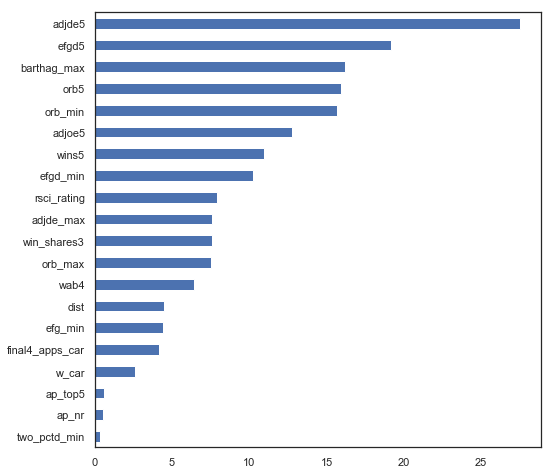

In [6412]:
#import LinearRegression
from sklearn.linear_model import LinearRegression

#train model
lr = LinearRegression()
lr.fit(train[pts_diff_columns.drop(['pts_diff'])], train['pts_diff'])
#get coefficients for each feature
coefficients = lr.coef_
feature_importance = pd.Series(coefficients, index=train[pts_diff_columns.drop(['pts_diff'])].columns)

#convert to positive values and sort
f, ax = plt.subplots(figsize=(8, 8))
feature_importance = feature_importance.abs().sort_values(ascending=False).sort_values()
feature_importance.plot.barh()
plt.show()

There is quite a big dropoff after w_car, so I will remove the bottom 3 columns. 

In [6413]:
#remove 3 columns by selecting the index of the first 17 rows
pts_diff_columns = feature_importance.sort_values(ascending=False).head(17).index

I still want to make sure that there is no multicollinearity, so the next set of code will be to display a heatmap of correlations.  

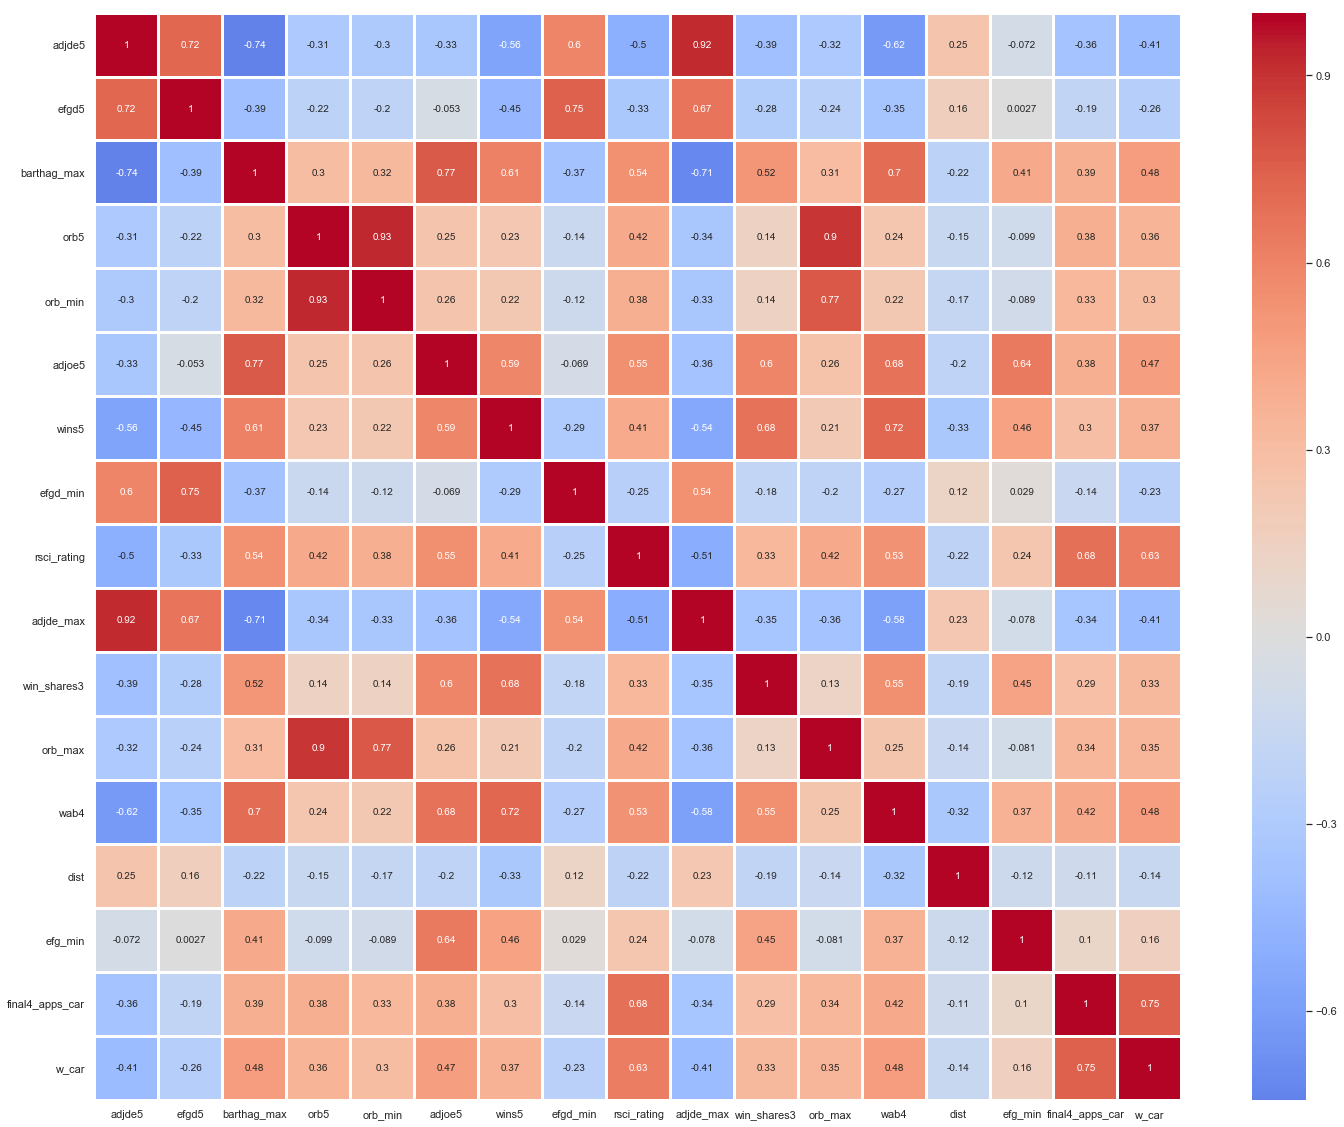

In [6414]:
#import matplotlib and use inline to display plot
import matplotlib.pyplot as plt
%matplotlib inline

#import seaborn
import seaborn as sns
  
#create figure to cutomize size of plot    
f, ax = plt.subplots(figsize=(25, 20))

#specify parameters and display heatmap 
sns.heatmap(train[pts_diff_columns].corr(), cmap='coolwarm', vmax=1, center=0,
square=True, linewidths=2, annot=True)
plt.show()

There are a few correlations above .7, so for each pair, I will remove the columns with the lowest importance according to the output from the regression model above. 

In [6415]:
pts_diff_columns = pts_diff_columns.drop(['adjde_max', 'orb_max', 'orb_min', 'efgd_min', 'w_car', 'adjoe5', 'wins5', 'win_shares3'])

This leaves me with the following variables that I will use as my model inputs:
    
- adjde5, 
- efgd5, 
- barthag_max
- orb5
- rsci_rating
- wab4
- dist
- efg_min
- final4_apps_car


### Linear regression model

The first model I will train is a linear regression model using r2 as a scroing metric, which is a measure of the amount of variance in the target variable that a model accounts for. r2 ranges between 0 and 1, and higher scores are better than lower. 

I will also be using 10 fold cross validation, meaning the training set will be split up into 10 sections, and 9 of the sections will be used to train the model with the other section used for testing. This is then repeated 10 times to get the average score for each fold. 

In [6416]:
#import cross val score to perform cross validation using 10 folds
from sklearn.model_selection import cross_val_score
# function to get mean cross validation r2 scores
def get_cv_scores(model):
    scores = cross_val_score(model,
                             train[pts_diff_columns],
                             train['pts_diff'],
                             cv=10,
                             scoring='r2')
    #print mean of r2 scores
    print('r2: ', np.mean(scores))
    
#fit linear regression model using get_cv_scores function
from sklearn.linear_model import LinearRegression
lr = LinearRegression().fit(train[pts_diff_columns], train['pts_diff'])
# get cross val scores
get_cv_scores(lr)   

r2:  0.39077382364692054


While the r2 is valuable to compare models, I am more interested in how accurate the model is on new data. Below, I will use the predict function to test the model on my holdout set, which includes all games from the 2019 tournament. Right now, the model is fit to predict the point spread, so I need to convert the predicted point spread to a predicted winner, and then compare these results with the actual winner. 

In [6417]:
#get predictions on holdout set
predictions = lr.predict(holdout[pts_diff_columns])

#create new column in holdout set with predictions
holdout['pred_pts_diff'] = predictions

#convert predictions to 1 or 0
holdout['pred_winner'] = holdout['pred_pts_diff'].apply(lambda x: 1 if x > 0 else 0)

#import confusion matrix
from sklearn.metrics import confusion_matrix
print("linear regression")
#print confusion matrix
print(confusion_matrix(holdout['winner'], holdout['pred_winner']))
from sklearn.metrics import accuracy_score
#view accuracy
accuracy_score(holdout['winner'], holdout['pred_winner'])

linear regression
[[16 11]
 [ 3 37]]


0.7910447761194029

The model correctly picked 53 of the 67 games for a 79% accuracy rate.

### K-nearest neigbors & random forest models using grid search

I will now try out a k-nearest neighbor model and a random forest model using grid search. I have created a function that includes a dictionary of different parameters, and grid search will train the models using each parameter to find the optimal input parameters. It will then print out the best score and parameters for each of the two model types.

In [6418]:
#import knn, random forest and grid search
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

#create function to perform grid search
def select_model(df,features):
    
    all_X = df[features]
    all_y = df['pts_diff']

    # List of dictionaries containing a model name, an estimator & a dict of hyperparameters
    models = [
        {
            "name": "KNeighborsRegressor",
            "estimator": KNeighborsRegressor(),
            "hyperparameters":
                {
                    "n_neighbors": range(1,20,2),
                    "weights": ["distance", "uniform"],
                    "algorithm": ["ball_tree", "kd_tree", "brute"],
                    "p": [1,2]
                }
        },
    
        {
            "name": "RandomForestRegressor",
            "estimator": RandomForestRegressor(random_state=1),
            "hyperparameters":
                {
                    "n_estimators": [4, 6, 9, 15, 25],
                    "criterion": ['mse', 'mae'],
                    "max_depth": [2, 5, 10],
                    "max_features": ["log2", "sqrt"],
                    "min_samples_leaf": [1, 5, 8],
                    "min_samples_split": [2, 3, 5]

                }
        }
    ]

    for model in models:
        print(model['name'])
        print('-'*len(model['name']))

        grid = GridSearchCV(model["estimator"],
                            param_grid=model["hyperparameters"],
                            scoring='r2',
                            cv=10)
        grid.fit(all_X,all_y)
        model["best_params"] = grid.best_params_
        model["best_score"] = grid.best_score_
        model["best_model"] = grid.best_estimator_

        print("Best Score: {}".format(model["best_score"]))
        print("Best Parameters: {}\n".format(model["best_params"]))

    return models

result = select_model(train, pts_diff_columns)

KNeighborsRegressor
-------------------
Best Score: 0.3346017372865623
Best Parameters: {'algorithm': 'ball_tree', 'n_neighbors': 17, 'p': 1, 'weights': 'distance'}

RandomForestRegressor
---------------------
Best Score: 0.372929229021444
Best Parameters: {'criterion': 'mae', 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 25}



On the training set, neither one performed as well as the linear regression model. I will view how accurate the two models are at making predictions on the holdout set

In [6419]:
#select knn model
knn_model = result[0]["best_model"]
#select rf model
rf_model = result[1]["best_model"]
#get knn predictions
knn_predictions = knn_model.predict(holdout[pts_diff_columns])
#get rf predictions
rf_predictions = rf_model.predict(holdout[pts_diff_columns])

#create columns in holdout table with predictions
holdout['knn_pred_pts'] = knn_predictions
holdout['rf_pred_pts'] = rf_predictions

#convert point spread to 1 or 0
holdout['knn_pred_winner'] = holdout['knn_pred_pts'].apply(lambda x: 1 if x > 0 else 0)
holdout['rf_pred_winner'] = holdout['rf_pred_pts'].apply(lambda x: 1 if x > 0 else 0)

#print results
print("knn")
#knn confusion matrix
print(confusion_matrix(holdout['winner'], holdout['knn_pred_winner']))
#knn accuracy
print(accuracy_score(holdout['winner'], holdout['knn_pred_winner']))
print("\n")
print("random forest")
#rf confusion matrix
print(confusion_matrix(holdout['winner'], holdout['rf_pred_winner']))
#rf accuracy
print(accuracy_score(holdout['winner'], holdout['rf_pred_winner']))


knn
[[18  9]
 [ 7 33]]
0.7611940298507462


random forest
[[17 10]
 [ 4 36]]
0.7910447761194029


The k-nearest neighbor model did not perform as well, but the random forest model proved to be just as accurate at the linear regression model by correctly picking 79% of games

## Classification Modeling: Predicting Winner

As opposed to predicting the point differential, another option is to use the winner binary column as the target variable. This is considered a classification type of modeling where the outcome is the probability of a 1 (winner). 

Using the same methods from the linear regression section, I found the following features to be the most valuable in predicting the winner:

- wab5
- wab4
- adjde5
- adjoe5
- seed
- dist


In [6420]:
winner_columns = ['wab5',
'wab4', 
'adjde5',
'adjoe5',
'seed',
'dist']

### Peform grid search on logistic regression,  knn, and random forest models

I'll use the columns as inputs to run grid search on logistic regression, knn and random forest models. Instead of printing out the r2 values like in the linear regression models, it will print out the accuracy rate.

In [6421]:
def select_model(df,features):
    
    all_X = df[features]
    all_y = df["winner"]


    models = [
        {
            "name": "LogisticRegression",
            "estimator": LogisticRegression(),
            "hyperparameters":
                {
                    "solver": ["newton-cg", "lbfgs", "liblinear"]
                }
        },
        {
            "name": "KNeighborsClassifier",
            "estimator": KNeighborsClassifier(),
            "hyperparameters":
                {
                    "n_neighbors": range(1,20,2),
                    "weights": ["distance", "uniform"],
                    "algorithm": ["ball_tree", "kd_tree", "brute"],
                    "p": [1,2]
                }
        },
        {
            "name": "RandomForestClassifier",
            "estimator": RandomForestClassifier(random_state=1),
            "hyperparameters":
                {
                    "n_estimators": [4, 6, 9, 15, 25],
                    "criterion": ["entropy", "gini"],
                    "max_depth": [2, 5, 10],
                    "max_features": ["log2", "sqrt"],
                    "min_samples_leaf": [1, 5, 8],
                    "min_samples_split": [2, 3, 5]

                }
        }
    ]

    for model in models:
        print(model['name'])
        print('-'*len(model['name']))

        grid = GridSearchCV(model["estimator"],
                            param_grid=model["hyperparameters"],
                            cv=10)
        grid.fit(all_X,all_y)
        model["best_params"] = grid.best_params_
        model["best_score"] = grid.best_score_
        model["best_model"] = grid.best_estimator_

        print("Best Score: {}".format(model["best_score"]))
        print("Best Parameters: {}\n".format(model["best_params"]))

    return models

result = select_model(train, winner_columns)

LogisticRegression
------------------
Best Score: 0.7111416781292985
Best Parameters: {'solver': 'newton-cg'}

KNeighborsClassifier
--------------------
Best Score: 0.7207702888583218
Best Parameters: {'algorithm': 'ball_tree', 'n_neighbors': 19, 'p': 2, 'weights': 'uniform'}

RandomForestClassifier
----------------------
Best Score: 0.71939477303989
Best Parameters: {'criterion': 'gini', 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 9}



On the training set, k-nearest neighbor had the highest accuracy. Below, I will view how well each did on the holdout data

In [6422]:
print("logistic regression")
#get logistic regression results
log_model = result[0]["best_model"]
log_predictions = log_model.predict(holdout[winner_columns])
holdout['log_predictions'] = log_predictions
#print confusion matrix
print(confusion_matrix(holdout['winner'], log_predictions))
#print accuracy
print(accuracy_score(holdout['winner'], log_predictions))
print("\n")

print("k-nearest neighbor")
#get results
knn_model = result[1]["best_model"]
knn_predictions = knn_model.predict(holdout[winner_columns])
holdout['knn_predictions'] = knn_predictions
#create confusion matrix
print(confusion_matrix(holdout['winner'], knn_predictions))
#print accuracy
print(accuracy_score(holdout['winner'], knn_predictions))
print("\n")

print("random forest")
#get results
rf_model = result[2]["best_model"]
rf_predictions = rf_model.predict(holdout[winner_columns])
holdout['rf_predictions'] = rf_predictions
#create confusion matrix
print(confusion_matrix(holdout['winner'], rf_predictions))
#print accuracy
print(accuracy_score(holdout['winner'], rf_predictions))

logistic regression
[[20  7]
 [10 30]]
0.746268656716418


k-nearest neighbor
[[21  6]
 [12 28]]
0.7313432835820896


random forest
[[17 10]
 [ 6 34]]
0.7611940298507462


The random forest model performed the best on the holdout data, but still not as well as the regressor models. However, I found that the variables used in these models performed best in terms of log loss, which is a measure of how close the predicted probabilities are to the actual results. For log loss, a lower score is better and below are results for each of the 3 models.

In [6423]:
#import and view log loss
from sklearn.metrics import log_loss

#create columns with predicted probabilities
holdout['log_pred_prob'] = log_model.predict_proba(holdout[winner_columns])[:,1]
holdout['knn_pred_prob'] = knn_model.predict_proba(holdout[winner_columns])[:,1]
holdout['rf_pred_prob'] = rf_model.predict_proba(holdout[winner_columns])[:,1]

#calculate log loss for logistic model
print("logistic regression log loss")
print(log_loss(holdout['winner'], holdout['log_pred_prob']))
print("\n")

#calculate log loss for knn model
print("knn log loss")
print(log_loss(holdout['winner'], holdout['knn_pred_prob']))
print("\n")

#calculate log loss for rf model
print("random forest log loss")
print(log_loss(holdout['winner'], holdout['rf_pred_prob']))
print("\n")

logistic regression log loss
0.46767008731426707


knn log loss
0.4982268888810608


random forest log loss
0.490327582194262




The logistic regression model did not perform as well in terms of overall correct predictions, but it gave the most accurate predicted probabilities with a log loss of .47.